<a href="https://colab.research.google.com/github/syfahernawati/notebook/blob/main/sales_online.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Online Sales Data - Time Series Analysis & Forecasting

**Notebook ini mencakup:**
1. Data Loading & Preprocessing
2. Exploratory Data Analysis (EDA)
3. Time Series Decomposition
4. Forecasting dengan Multiple Models
5. Model Evaluation & Comparison

---

## 1. Import Libraries & Setup

In [ ]:
# Install required packages jika belum ada
# !pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time Series specific imports
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Semua library berhasil diimport!")

✅ Semua library berhasil diimport!


In [ ]:
## 2. Data Loading & Preprocessing

In [ ]:
# Install openml if not already installed
!pip install openml

import openml
df, _, _, _ = openml.datasets.get_dataset(46079).get_data(dataset_format="dataframe")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.7 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=1cc0478979b71071a91c3cc097428b93fc76388a827b481d2d94c79fde2b09a0
  Stored in directory: /root/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff


In [ ]:
df.rename(columns={
    'Transaction ID': 'Transaction_ID',
    'Product Category': 'Product_Category',
    'Product Name': 'Product_Name',
    'Units Sold': 'Units_Sold',
    'Unit Price': 'Unit_Price',
    'Total Revenue': 'Total_Revenue',
    'Payment Method': 'Payment_Method'
}, inplace=True)

# Convert string columns to numeric types
df['Units_Sold'] = pd.to_numeric(df['Units_Sold'])
df['Unit_Price'] = pd.to_numeric(df['Unit_Price'])
df['Total_Revenue'] = pd.to_numeric(df['Total_Revenue'])

# Mengkonversi kolom 'Date' ke tipe datetime
# Gunakan format yang sesuai dengan data Anda (Tahun-Bulan-Hari Jam:Menit:Detik)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')



# Menampilkan informasi ringkas untuk memverifikasi tipe data
print("\nInformasi DataFrame Setelah Konversi Date:")
df.info()



print(f"Dataset shape: {df.shape}")
print(f"\nKolom: {df.columns.tolist()}")
df.head(10)


Informasi DataFrame Setelah Konversi Date:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction_ID    240 non-null    object        
 1   Date              240 non-null    datetime64[ns]
 2   Product_Category  240 non-null    category      
 3   Product_Name      240 non-null    object        
 4   Units_Sold        240 non-null    uint8         
 5   Unit_Price        240 non-null    float64       
 6   Total_Revenue     240 non-null    float64       
 7   Region            240 non-null    category      
 8   Payment_Method    240 non-null    category      
dtypes: category(3), datetime64[ns](1), float64(2), object(2), uint8(1)
memory usage: 10.9+ KB
Dataset shape: (240, 9)

Kolom: ['Transaction_ID', 'Date', 'Product_Category', 'Product_Name', 'Units_Sold', 'Unit_Price', 'Total_Revenue', 'Region', 'Payment_Meth

,Transaction_ID,Date,Product_Category,Product_Name,Units_Sold,Unit_Price,Total_Revenue,Region,Payment_Method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal
5,10006,2024-01-06,Sports,Wilson Evolution Basketball,5,29.99,149.95,Asia,Credit Card
6,10007,2024-01-07,Electronics,MacBook Pro 16-inch,1,2499.99,2499.99,North America,Credit Card
7,10008,2024-01-08,Home Appliances,Blueair Classic 480i,2,599.99,1199.98,Europe,PayPal
8,10009,2024-01-09,Clothing,Nike Air Force 1,6,89.99,539.94,Asia,Debit Card
9,10010,2024-01-10,Books,Dune by Frank Herbert,2,25.99,51.98,North America,Credit Card


In [ ]:
# Penjualan berdasarkan Wilayah (Total Revenue)
revenue_by_region = df.groupby('Region')['Total_Revenue'].sum().sort_values(ascending=False)
print("\n--- Total Pendapatan berdasarkan Wilayah ---")
print(revenue_by_region) # pendapatan per wilayah

# Menghitung Metode Pembayaran yang Paling Sering digunakan apa aja
payment_counts = df['Payment_Method'].value_counts()
print("\n--- Frekuensi Metode Pembayaran ---")
print(payment_counts) # metode pembayaran


--- Total Pendapatan berdasarkan Wilayah ---
Region
North America    36844.34
Asia             22455.45
Europe           21268.06
Name: Total_Revenue, dtype: float64

--- Frekuensi Metode Pembayaran ---
Payment_Method
Credit Card    120
PayPal          80
Debit Card      40
Name: count, dtype: int64


In [ ]:
# Data type conversion
df['Date'] = pd.to_datetime(df['Date'])
df['Transaction_ID'] = df['Transaction_ID'].astype(str)

# Check data types
print("Data Types:")
print(df.dtypes)
print(f"\nRentang waktu: {df['Date'].min()} - {df['Date'].max()}")
print(f"Total hari: {(df['Date'].max() - df['Date'].min()).days} hari")

Data Types:
Transaction_ID              object
Date                datetime64[ns]
Product_Category          category
Product_Name                object
Units_Sold                   uint8
Unit_Price                 float64
Total_Revenue              float64
Region                    category
Payment_Method            category
dtype: object

Rentang waktu: 2024-01-01 00:00:00 - 2024-08-27 00:00:00
Total hari: 239 hari


In [ ]:
# Check missing values
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")

Missing Values:
Transaction_ID      0
Date                0
Product_Category    0
Product_Name        0
Units_Sold          0
Unit_Price          0
Total_Revenue       0
Region              0
Payment_Method      0
dtype: int64

Total missing: 0


In [ ]:
# Tambahkan code untuk mengecek duplikat data
duplicates = df[df.duplicated()]
print("Jumlah duplikat data:", len(duplicates))

if not duplicates.empty:
    print("\nContoh baris duplikat:")
    print(duplicates.head())
else:
    print("Tidak ada duplikat data dalam DataFrame.")

Jumlah duplikat data: 0
Tidak ada duplikat data dalam DataFrame.


In [ ]:
# Basic statistics
print("Statistik Deskriptif - Kolom Numerik:")
df[['Units_Sold', 'Unit_Price', 'Total_Revenue']].describe()


Statistik Deskriptif - Kolom Numerik:


,Units_Sold,Unit_Price,Total_Revenue
count,240.000000,240.000000,240.000000
mean,2.158333,236.395583,335.699375
std,1.322454,429.446695,485.804469
min,1.000000,6.500000,6.500000
25%,1.000000,29.500000,62.965000
50%,2.000000,89.990000,179.970000
75%,3.000000,249.990000,399.225000
max,10.000000,3899.990000,3899.990000


## 3. Exploratory Data Analysis (EDA)

### 3.1 Distribusi Kategori

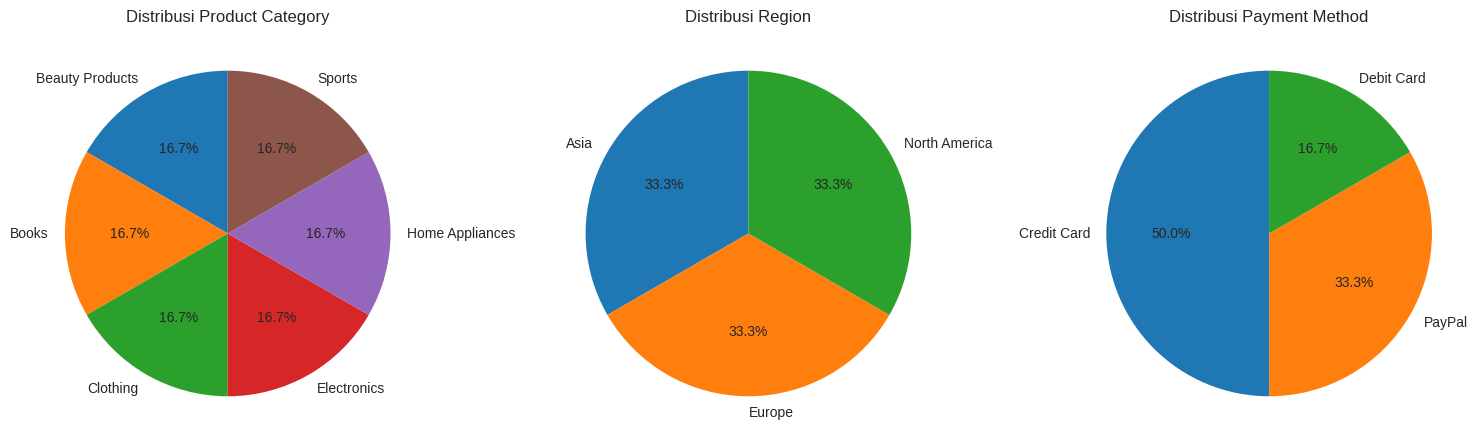

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Product
#Semua kategori memiliki porsi yang sama, yaitu 16,7% masing-masing syif
#Artinya apa?

#Tidak ada kategori yang dominan

#Penjualan atau data produk terdistribusi merata di semua kategori

#Setiap kategori menyumbang kontribusi yang seimbang terhadap total
cat_counts = df['Product_Category'].value_counts()
axes[0].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribusi Product Category')

# Region
region_counts = df['Region'].value_counts()
axes[1].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribusi Region')

# Payment
# payment yang paling dominan adalah credit card, Pay pal termasuk populer, dan debit card paling sedikit syif
payment_counts = df['Payment_Method'].value_counts()
axes[2].pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('Distribusi Payment Method')

plt.tight_layout()
plt.show()


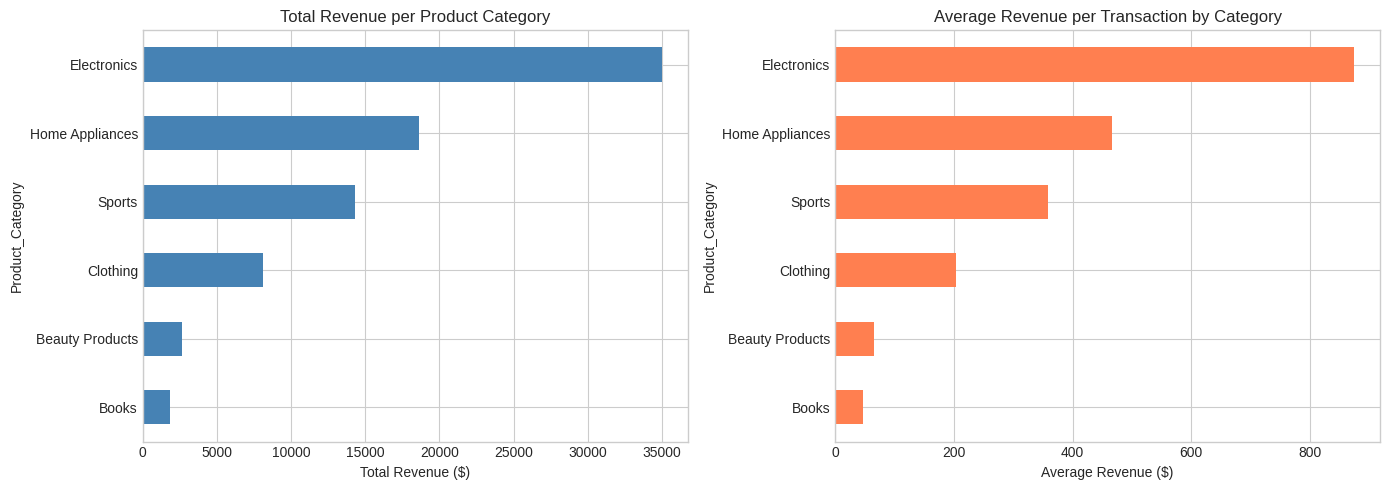

In [ ]:
# Revenue by Category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total Revenue per
#Urutan kontribusi pendapatan yah syif.

#Electronics → paling tinggi (± $35.000)
#Home Appliances → kedua tertinggi (± $18.000)
#Sports → menengah (± $15.000)
#Clothing → lebih rendah (± $8.000)
#Beauty Products → rendah (± $3.000)
#Books → paling rendah (± $2.000)

revenue_by_cat = df.groupby('Product_Category')['Total_Revenue'].sum().sort_values(ascending=True)
revenue_by_cat.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Total Revenue per Product Category')
axes[0].set_xlabel('Total Revenue ($)')

# Average Revenue per Transaction by Category
#Urutan nilai rata-rata transaksi yahh

#Electronics → tertinggi (± $900 per transaksi)
#Home Appliances → tinggi (± $450)
#Sports → menengah (± $350)
#Clothing → lebih rendah (± $200)
#Beauty Products → rendah (± $70)
#Books → paling rendah (± $50)
avg_revenue_by_cat = df.groupby('Product_Category')['Total_Revenue'].mean().sort_values(ascending=True)
avg_revenue_by_cat.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Average Revenue per Transaction by Category')
axes[1].set_xlabel('Average Revenue ($)')

plt.tight_layout()
plt.show()

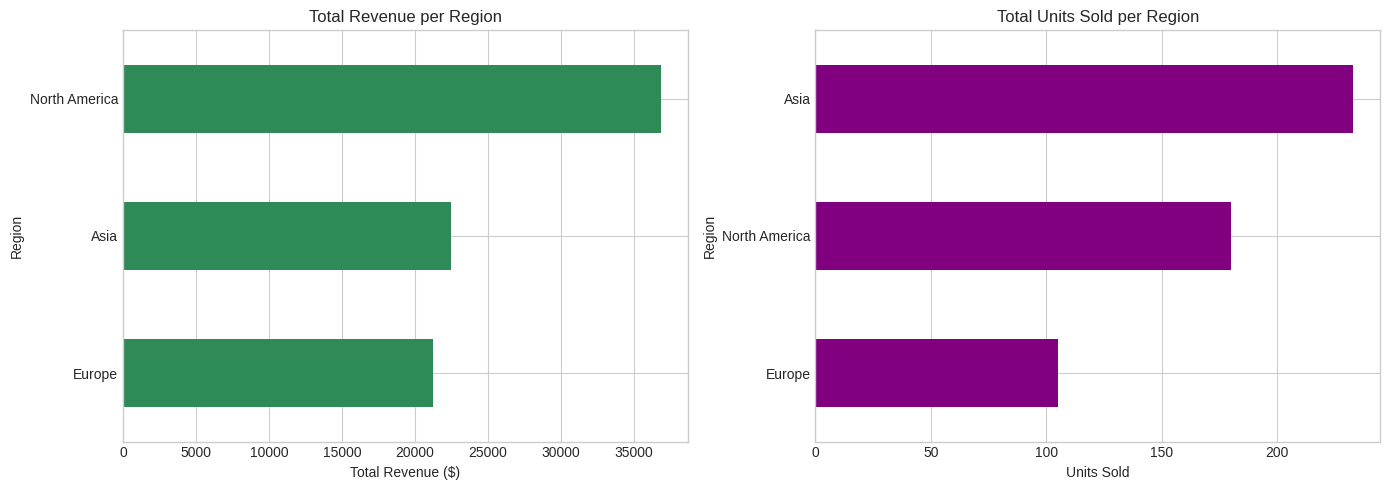

In [ ]:
# Revenue by Region
#Hasil utama ya

#North America → tertinggi (± $37.000)
#Asia → menengah (± $23.000)
#Europe → sedikit di bawah Asia (± $21.000)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

revenue_by_region = df.groupby('Region')['Total_Revenue'].sum().sort_values(ascending=True)
revenue_by_region.plot(kind='barh', ax=axes[0], color='seagreen')
axes[0].set_title('Total Revenue per Region')
axes[0].set_xlabel('Total Revenue ($)')

# Units Sold by Region
#Hasil utama ya

#Asia → unit terjual paling banyak (± 230 unit)
#North America → kedua (± 180 unit)
#Europe → paling sedikit (± 105 unit)
units_by_region = df.groupby('Region')['Units_Sold'].sum().sort_values(ascending=True)
units_by_region.plot(kind='barh', ax=axes[1], color='purple')
axes[1].set_title('Total Units Sold per Region')
axes[1].set_xlabel('Units Sold')

plt.tight_layout()
plt.show()

### 3.2 Distribusi Numerik

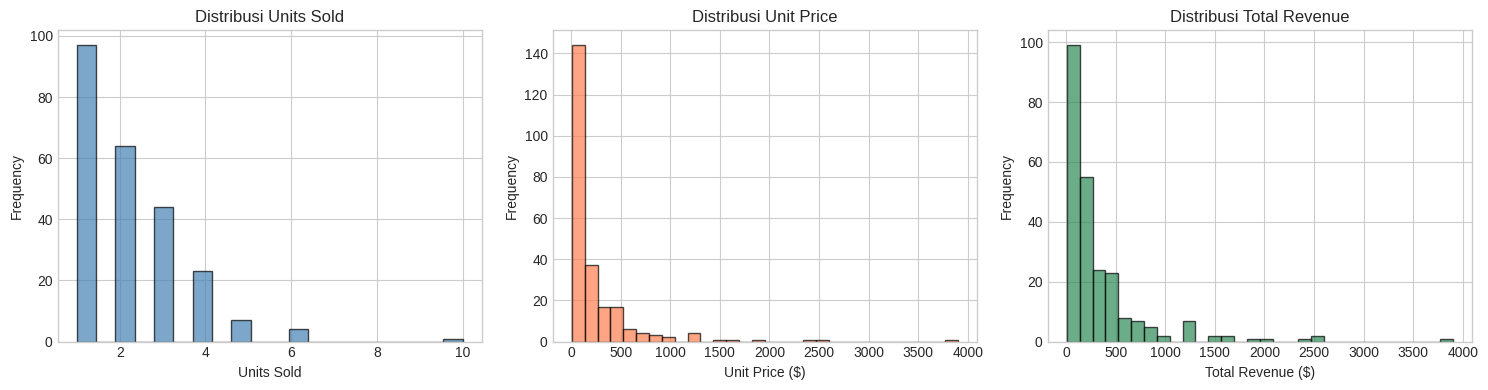

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Units Sold distribution
axes[0].hist(df['Units_Sold'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribusi Units Sold')
axes[0].set_xlabel('Units Sold')
axes[0].set_ylabel('Frequency')

# Unit Price distribution
axes[1].hist(df['Unit_Price'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribusi Unit Price')
axes[1].set_xlabel('Unit Price ($)')
axes[1].set_ylabel('Frequency')

# Total Revenue distribution
axes[2].hist(df['Total_Revenue'], bins=30, color='seagreen', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribusi Total Revenue')
axes[2].set_xlabel('Total Revenue ($)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

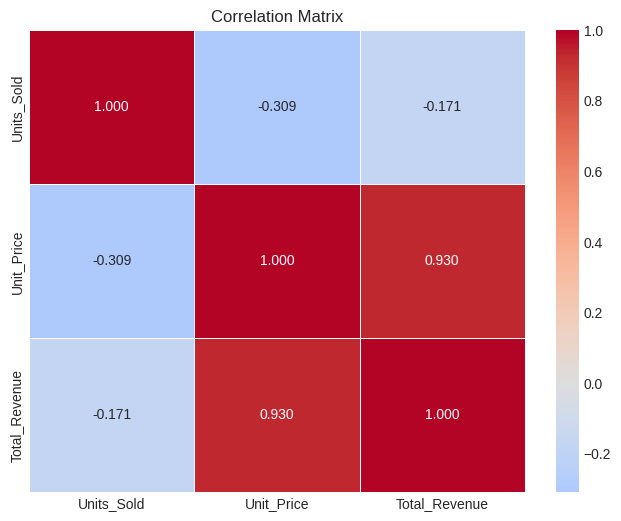

In [ ]:
# Correlation heatmap
#Nilai penting:

#Unit Price ↔ Total Revenue = 0.93 (sangat kuat & positif)

#Units Sold ↔ Unit Price = -0.31 (negatif lemah)

#units Sold ↔ Total Revenue = -0.17 (sangat lemah)
numeric_cols = df[['Units_Sold', 'Unit_Price', 'Total_Revenue']]
correlation = numeric_cols.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### 3.3 Analisis Time Series

In [ ]:
# Agregasi data per hari
daily_sales = df.groupby('Date').agg({
    'Total_Revenue': 'sum',
    'Units_Sold': 'sum',
    'Transaction_ID': 'count'
}).rename(columns={'Transaction_ID': 'Num_Transactions'})

print(f"Daily sales shape: {daily_sales.shape}")
daily_sales.head(10)

Daily sales shape: (240, 3)


,Total_Revenue,Units_Sold,Num_Transactions
Date,,,
2024-01-01,1999.98,2,1
2024-01-02,499.99,1,1
2024-01-03,209.97,3,1
2024-01-04,63.96,4,1
2024-01-05,89.99,1,1
2024-01-06,149.95,5,1
2024-01-07,2499.99,1,1
2024-01-08,1199.98,2,1
2024-01-09,539.94,6,1


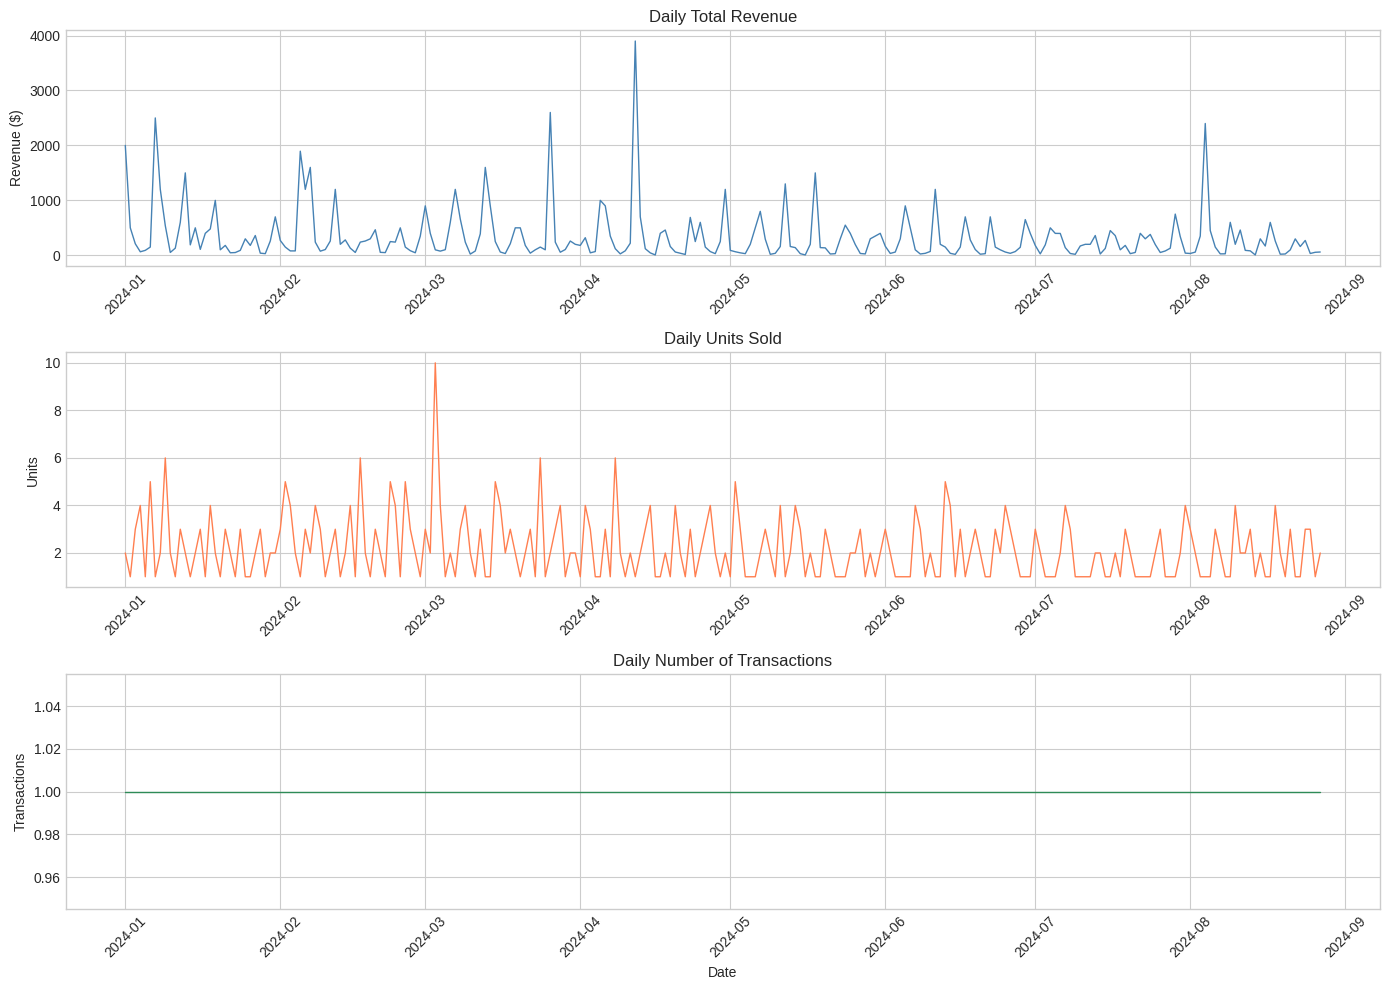

In [ ]:
# Plot time series harian
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Daily Revenue
axes[0].plot(daily_sales.index, daily_sales['Total_Revenue'], color='steelblue', linewidth=1)
axes[0].set_title('Daily Total Revenue')
axes[0].set_ylabel('Revenue ($)')
axes[0].tick_params(axis='x', rotation=45)

# Daily Units Sold
axes[1].plot(daily_sales.index, daily_sales['Units_Sold'], color='coral', linewidth=1)
axes[1].set_title('Daily Units Sold')
axes[1].set_ylabel('Units')
axes[1].tick_params(axis='x', rotation=45)

# Daily Transactions
axes[2].plot(daily_sales.index, daily_sales['Num_Transactions'], color='seagreen', linewidth=1)
axes[2].set_title('Daily Number of Transactions')
axes[2].set_ylabel('Transactions')
axes[2].set_xlabel('Date')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Agregasi per minggu untuk tren yang lebih jelas
weekly_sales = df.set_index('Date').resample('W').agg({
    'Total_Revenue': 'sum',
    'Units_Sold': 'sum',
    'Transaction_ID': 'count'
}).rename(columns={'Transaction_ID': 'Num_Transactions'})

print(f"Weekly sales shape: {weekly_sales.shape}")
weekly_sales.head(10)

Weekly sales shape: (35, 3)


,Total_Revenue,Units_Sold,Num_Transactions
Date,,,
2024-01-07,5513.83,17,7
2024-01-14,4211.83,17,7
2024-01-21,2767.84,16,7
2024-01-28,1064.87,13,7
2024-02-04,1569.81,19,7
2024-02-11,5374.86,16,7
2024-02-18,2361.86,19,7
2024-02-25,1857.84,17,7
2024-03-03,2028.80,26,7


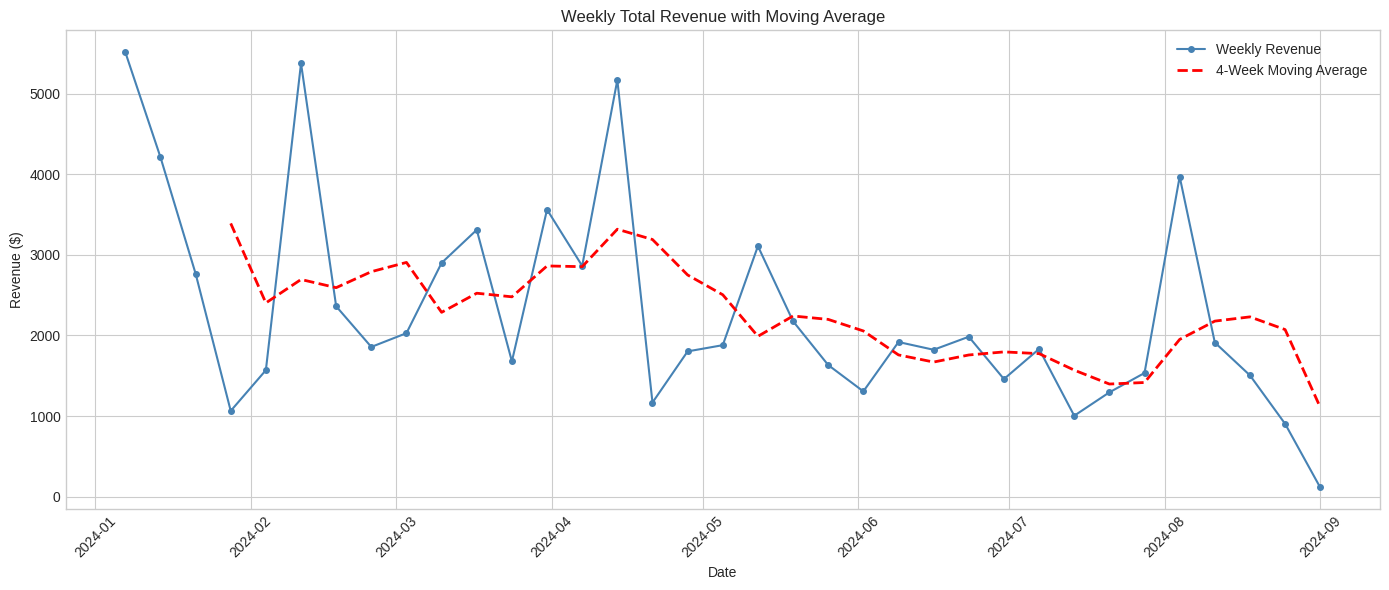

In [ ]:
# Plot Weekly Time Series dengan Moving Average
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(weekly_sales.index, weekly_sales['Total_Revenue'],
        label='Weekly Revenue', color='steelblue', linewidth=1.5, marker='o', markersize=4)

# Moving Average 4 minggu
ma_4 = weekly_sales['Total_Revenue'].rolling(window=4).mean()
ax.plot(weekly_sales.index, ma_4, label='4-Week Moving Average',
        color='red', linewidth=2, linestyle='--')

ax.set_title('Weekly Total Revenue with Moving Average')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue ($)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Agregasi per bulan
monthly_sales = df.set_index('Date').resample('ME').agg({
    'Total_Revenue': 'sum',
    'Units_Sold': 'sum',
    'Transaction_ID': 'count'
}).rename(columns={'Transaction_ID': 'Num_Transactions'})

monthly_sales['Month'] = monthly_sales.index.strftime('%Y-%m')
print("Monthly Sales Summary:")
monthly_sales

Monthly Sales Summary:


,Total_Revenue,Units_Sold,Num_Transactions,Month
Date,,,,
2024-01-31,14548.32,68,31,2024-01
2024-02-29,10803.37,77,29,2024-02
2024-03-31,12849.24,82,31,2024-03
2024-04-30,12451.69,65,30,2024-04
2024-05-31,8455.49,60,31,2024-05
2024-06-30,7384.55,61,30,2024-06
2024-07-31,6797.08,53,31,2024-07
2024-08-31,7278.11,52,27,2024-08


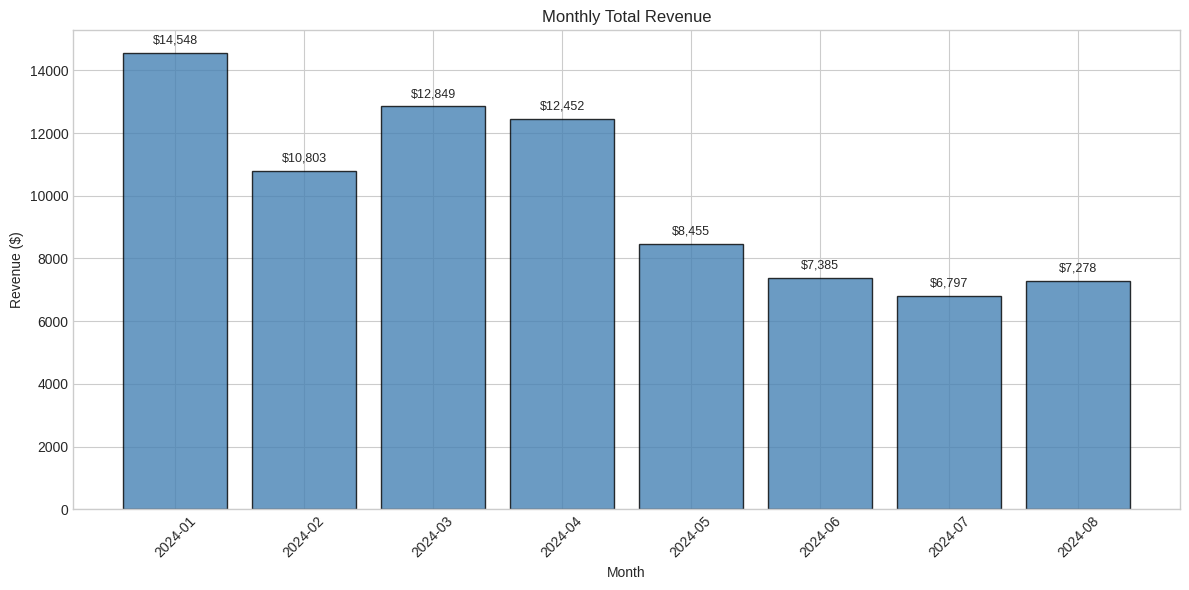

In [ ]:
# Plot Monthly Revenue
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(monthly_sales['Month'], monthly_sales['Total_Revenue'],
              color='steelblue', edgecolor='black', alpha=0.8)

# Tambah label value di atas bar
for bar, val in zip(bars, monthly_sales['Total_Revenue']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'${val:,.0f}', ha='center', va='bottom', fontsize=9)

ax.set_title('Monthly Total Revenue')
ax.set_xlabel('Month')
ax.set_ylabel('Revenue ($)')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

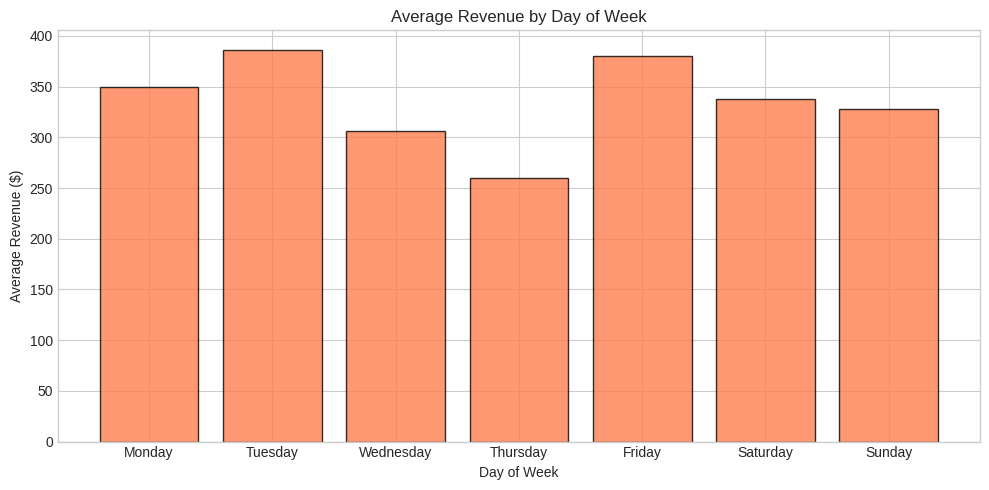

In [ ]:
# Day of Week Analysis
df['DayOfWeek'] = df['Date'].dt.day_name()
df['DayOfWeekNum'] = df['Date'].dt.dayofweek

dow_revenue = df.groupby(['DayOfWeekNum', 'DayOfWeek'])['Total_Revenue'].mean().reset_index()
dow_revenue = dow_revenue.sort_values('DayOfWeekNum')

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(dow_revenue['DayOfWeek'], dow_revenue['Total_Revenue'],
              color='coral', edgecolor='black', alpha=0.8)
ax.set_title('Average Revenue by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Revenue ($)')
plt.tight_layout()
plt.show()

## 4. Time Series Decomposition

In [ ]:
# Gunakan weekly data untuk decomposition (lebih stabil)
ts_data = weekly_sales['Total_Revenue'].copy()
ts_data = ts_data.asfreq('W')  # Pastikan frequency

print(f"Time series length: {len(ts_data)}")
print(f"Frequency: {ts_data.index.freq}")
ts_data.head()

Time series length: 35
Frequency: <Week: weekday=6>


,Total_Revenue
Date,
2024-01-07,5513.83
2024-01-14,4211.83
2024-01-21,2767.84
2024-01-28,1064.87
2024-02-04,1569.81


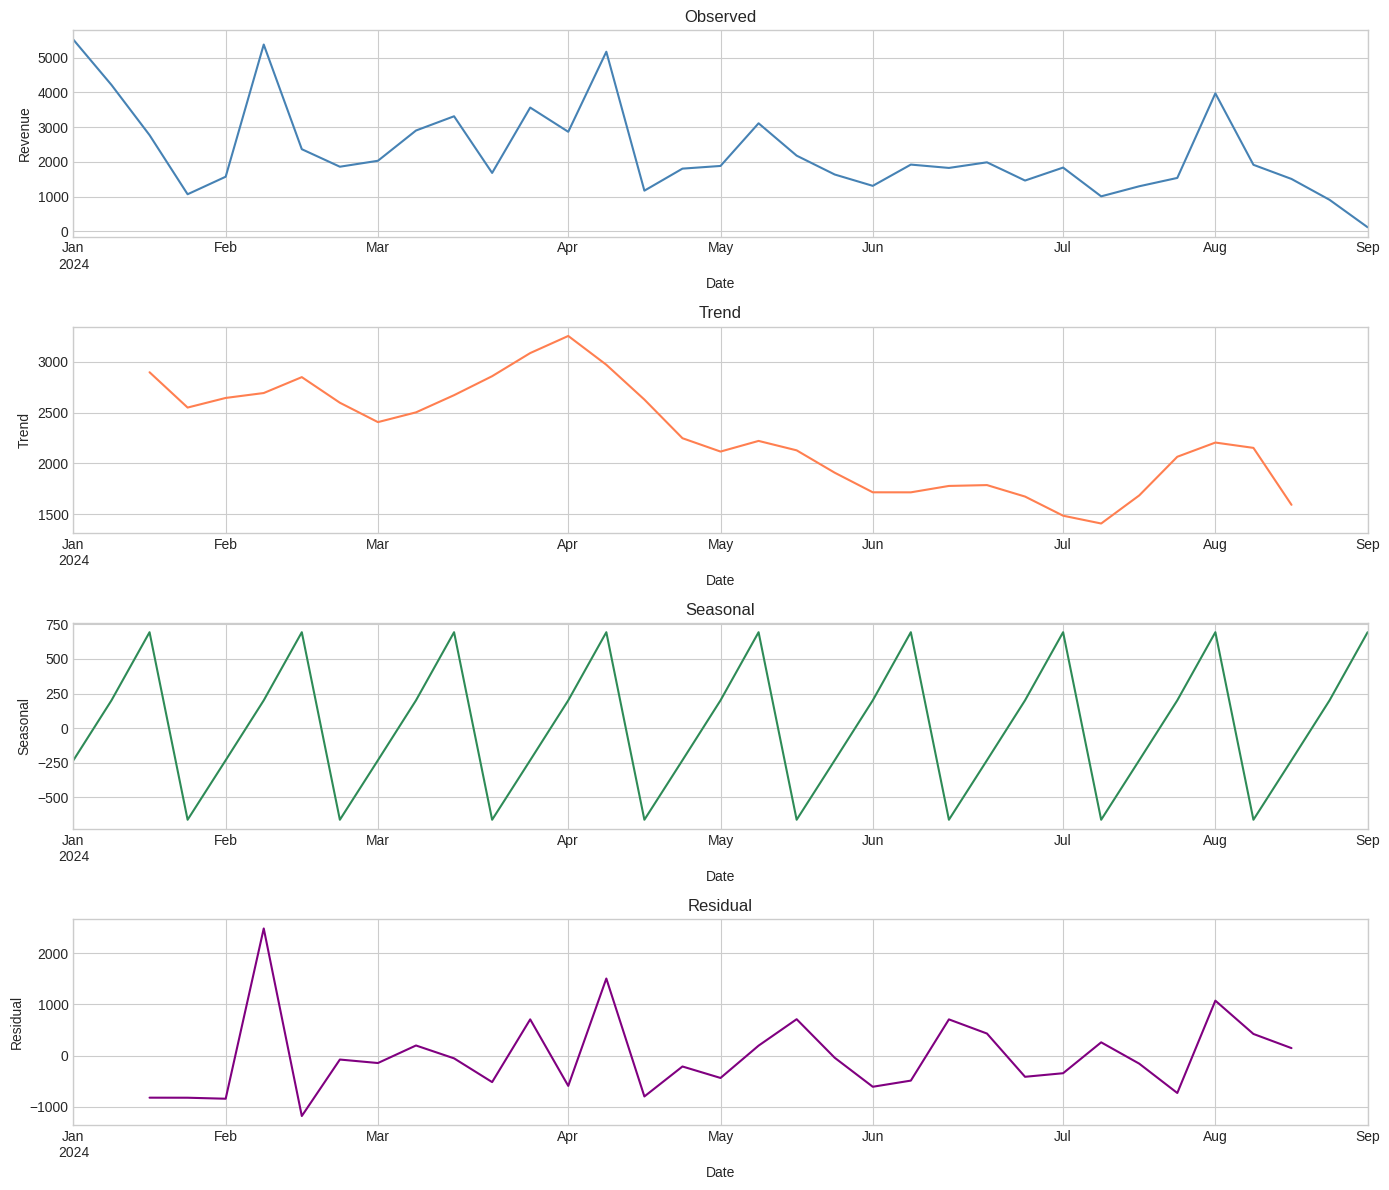

In [ ]:
# Seasonal Decomposition
# Karena data hanya 8 bulan, gunakan period=4 (4 minggu ~ 1 bulan)
decomposition = seasonal_decompose(ts_data, model='additive', period=4)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

decomposition.observed.plot(ax=axes[0], title='Observed', color='steelblue')
axes[0].set_ylabel('Revenue')

decomposition.trend.plot(ax=axes[1], title='Trend', color='coral')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='seagreen')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], title='Residual', color='purple')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 5. Stationarity Test

In [ ]:
def adf_test(series, title=''):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna(), autolag='AIC')

    print(f'ADF Test Results - {title}')
    print('='*50)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Lags Used: {result[2]}')
    print(f'Number of Observations: {result[3]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')

    if result[1] <= 0.05:
        print('\n✅ Conclusion: Series is STATIONARY (reject H0)')
    else:
        print('\n⚠️ Conclusion: Series is NON-STATIONARY (fail to reject H0)')
    print()

# Test original series
adf_test(ts_data, 'Weekly Revenue (Original)')

ADF Test Results - Weekly Revenue (Original)
ADF Statistic: -4.8097
p-value: 0.0001
Lags Used: 0
Number of Observations: 34
Critical Values:
   1%: -3.6392
   5%: -2.9512
   10%: -2.6144

✅ Conclusion: Series is STATIONARY (reject H0)



In [ ]:
# Differencing jika non-stationary
ts_diff = ts_data.diff().dropna()
adf_test(ts_diff, 'Weekly Revenue (1st Difference)')

ADF Test Results - Weekly Revenue (1st Difference)
ADF Statistic: -2.5906
p-value: 0.0950
Lags Used: 10
Number of Observations: 23
Critical Values:
   1%: -3.7529
   5%: -2.9985
   10%: -2.6390

⚠️ Conclusion: Series is NON-STATIONARY (fail to reject H0)



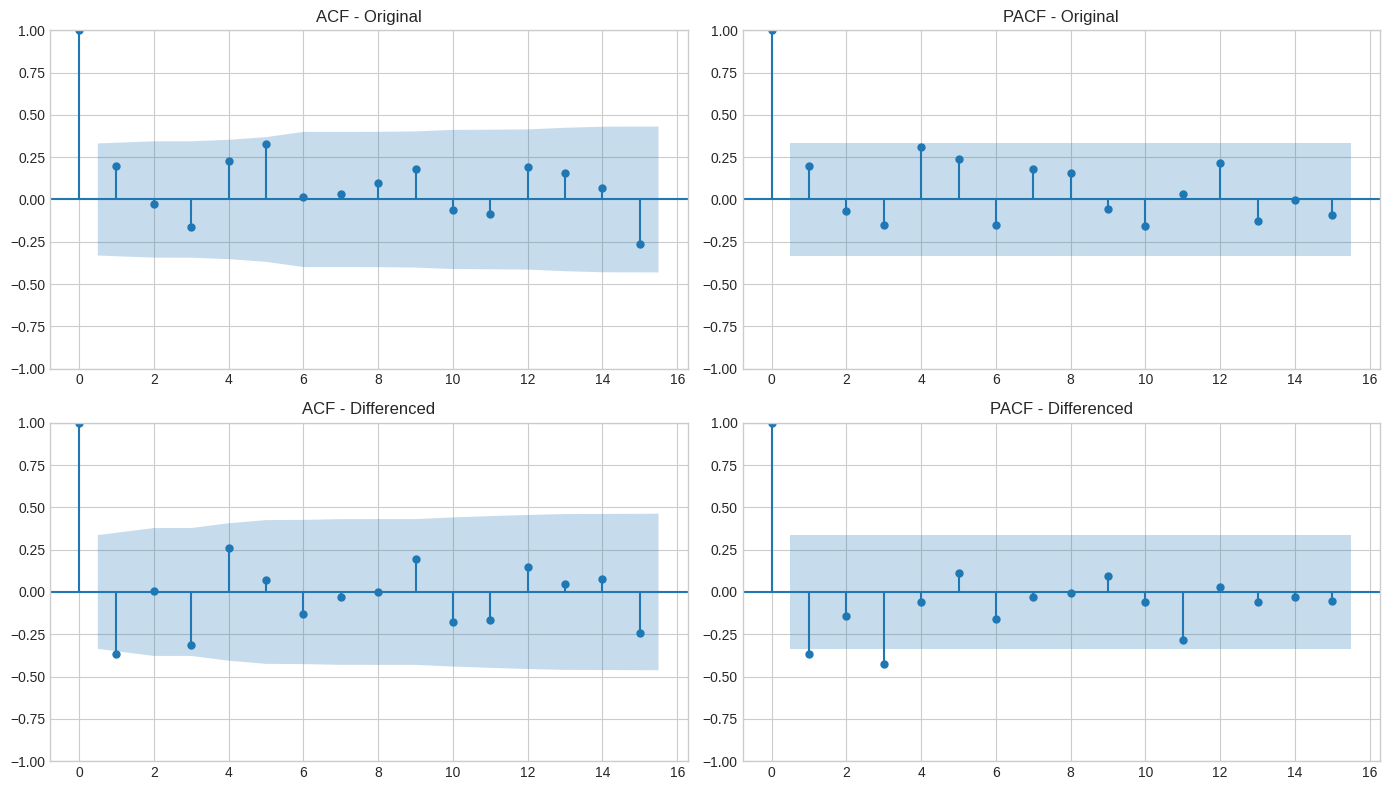

In [ ]:
# ACF dan PACF plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original series
plot_acf(ts_data, lags=15, ax=axes[0, 0], title='ACF - Original')
plot_pacf(ts_data, lags=15, ax=axes[0, 1], title='PACF - Original')

# Differenced series
plot_acf(ts_diff, lags=15, ax=axes[1, 0], title='ACF - Differenced')
plot_pacf(ts_diff, lags=15, ax=axes[1, 1], title='PACF - Differenced')

plt.tight_layout()
plt.show()

## 6. Train-Test Split

Train size: 28 weeks (2024-01-07 00:00:00 to 2024-07-14 00:00:00)
Test size: 7 weeks (2024-07-21 00:00:00 to 2024-09-01 00:00:00)


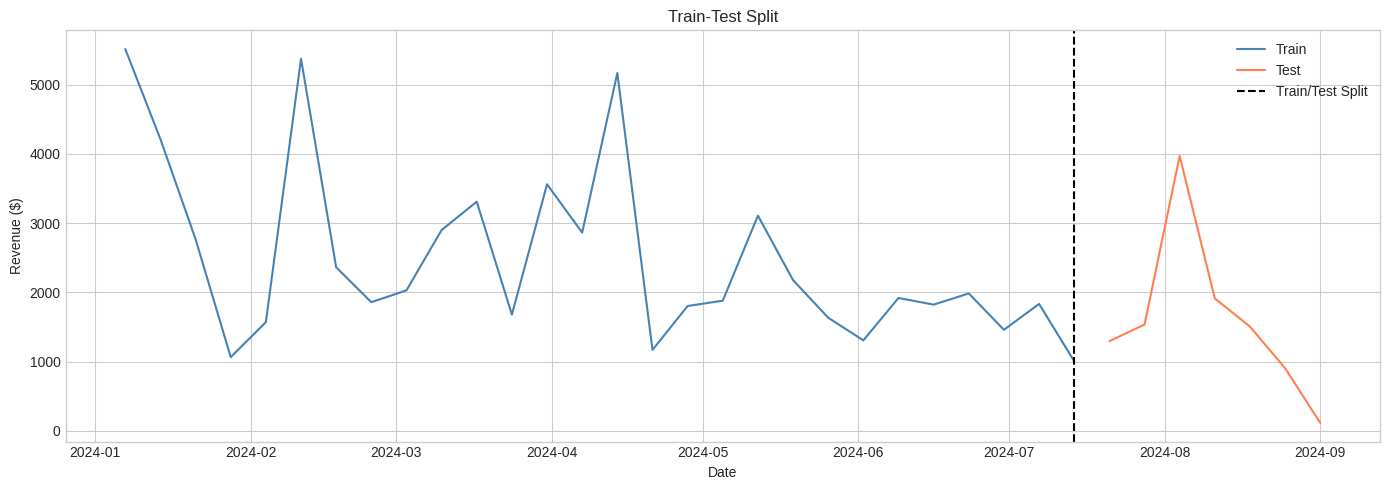

In [ ]:
# Split data: 80% train, 20% test
train_size = int(len(ts_data) * 0.8)
train = ts_data[:train_size]
test = ts_data[train_size:]

print(f"Train size: {len(train)} weeks ({train.index.min()} to {train.index.max()})")
print(f"Test size: {len(test)} weeks ({test.index.min()} to {test.index.max()})")

# Visualize split
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train.index, train, label='Train', color='steelblue')
ax.plot(test.index, test, label='Test', color='coral')
ax.axvline(x=train.index[-1], color='black', linestyle='--', label='Train/Test Split')
ax.set_title('Train-Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue ($)')
ax.legend()
plt.tight_layout()
plt.show()

## 7. Forecasting Models

In [ ]:
# Helper function untuk evaluasi
def evaluate_forecast(actual, predicted, model_name):
    """Calculate and display forecast metrics"""
    global results # Ensure we are modifying the global results list

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"\n{model_name} - Evaluation Metrics:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAPE: {mape:.2f}%")

    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Store results - Explicitly re-initialize to ensure it's a list
results = []

### 7.1 Naive Forecast (Baseline)

In [ ]:
# Naive: Use last observed value as forecast
naive_forecast = pd.Series([train.iloc[-1]] * len(test), index=test.index)

results.append(evaluate_forecast(test, naive_forecast, 'Naive (Baseline)'))


Naive (Baseline) - Evaluation Metrics:
  MAE:  $883.36
  RMSE: $1,255.37
  MAPE: 142.47%


### 7.2 Simple Moving Average

In [ ]:
# Moving Average dengan window 4 minggu
window = 4
ma_value = train.iloc[-window:].mean()
sma_forecast = pd.Series([ma_value] * len(test), index=test.index)

results.append(evaluate_forecast(test, sma_forecast, f'Simple MA (window={window})'))


Simple MA (window=4) - Evaluation Metrics:
  MAE:  $748.35
  RMSE: $1,102.97
  MAPE: 206.51%


### 7.3 Exponential Smoothing (Holt-Winters)

In [ ]:
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.3, optimized=False)
ses_forecast = ses_model.forecast(len(test))
ses_forecast.index = test.index

results.append(evaluate_forecast(test, ses_forecast, 'Simple Exp Smoothing'))


Simple Exp Smoothing - Evaluation Metrics:
  MAE:  $744.17
  RMSE: $1,103.32
  MAPE: 204.96%


In [ ]:
# Holt's Linear Trend Method
from statsmodels.tsa.holtwinters import Holt

holt_model = Holt(train).fit(smoothing_level=0.3, smoothing_trend=0.1)
holt_forecast = holt_model.forecast(len(test))
holt_forecast.index = test.index

results.append(evaluate_forecast(test, holt_forecast, "Holt's Linear Trend"))


Holt's Linear Trend - Evaluation Metrics:
  MAE:  $912.04
  RMSE: $1,303.15
  MAPE: 81.02%


/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [ ]:
# Holt-Winters (dengan seasonal) - period=4 untuk monthly pattern
try:
    hw_model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=4
    ).fit()
    hw_forecast = hw_model.forecast(len(test))
    hw_forecast.index = test.index
    results.append(evaluate_forecast(test, hw_forecast, 'Holt-Winters (Additive)'))
except Exception as e:
    print(f"Holt-Winters failed: {e}")
    hw_forecast = None


Holt-Winters (Additive) - Evaluation Metrics:
  MAE:  $899.28
  RMSE: $1,159.97
  MAPE: 207.12%


### 7.4 ARIMA Model

In [ ]:
# ARIMA dengan parameter manual berdasarkan ACF/PACF
# p=1, d=1, q=1 sebagai starting point

arima_model = ARIMA(train, order=(1, 1, 1)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:          Total_Revenue   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -229.251
Date:                Thu, 08 Jan 2026   AIC                            464.502
Time:                        02:04:47   BIC                            468.389
Sample:                    01-07-2024   HQIC                           465.658
                         - 07-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0479      0.240      0.199      0.842      -0.423       0.518
ma.L1         -0.8546      0.314     -2.720      0.007      -1.470      -0.239
sigma2      1.347e+06   5.35e+05      2.517      0.0

In [ ]:
# ARIMA forecast
arima_forecast = arima_model.forecast(steps=len(test))
arima_forecast.index = test.index

results.append(evaluate_forecast(test, arima_forecast, 'ARIMA(1,1,1)'))


ARIMA(1,1,1) - Evaluation Metrics:
  MAE:  $865.84
  RMSE: $1,128.30
  MAPE: 251.84%


In [ ]:
# Try different ARIMA parameters
best_aic = float('inf')
best_order = None
best_model = None

print("Searching for best ARIMA parameters...")
for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            try:
                model = ARIMA(train, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
                    best_model = model
            except:
                continue

print(f"\nBest ARIMA order: {best_order}")
print(f"Best AIC: {best_aic:.2f}")

Searching for best ARIMA parameters...

Best ARIMA order: (0, 1, 1)
Best AIC: 462.54


In [ ]:
# Forecast dengan best ARIMA
best_arima_forecast = best_model.forecast(steps=len(test))
best_arima_forecast.index = test.index

results.append(evaluate_forecast(test, best_arima_forecast, f'ARIMA{best_order} (Best)'))


ARIMA(0, 1, 1) (Best) - Evaluation Metrics:
  MAE:  $860.11
  RMSE: $1,125.30
  MAPE: 247.92%


### 7.5 Prophet

In [ ]:
# Prophet requires specific format
try:
    from prophet import Prophet

    # Prepare data for Prophet
    prophet_train = pd.DataFrame({
        'ds': train.index,
        'y': train.values
    })

    # Fit model
    prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=False,
                           daily_seasonality=False)
    prophet_model.fit(prophet_train)

    # Create future dataframe
    future = pd.DataFrame({'ds': test.index})
    prophet_forecast_df = prophet_model.predict(future)
    prophet_forecast = pd.Series(prophet_forecast_df['yhat'].values, index=test.index)

    results.append(evaluate_forecast(test, prophet_forecast, 'Prophet'))
    prophet_available = True

except ImportError:
    print("Prophet not installed. Skipping Prophet model.")
    print("Install with: pip install prophet")
    prophet_forecast = None
    prophet_available = False

INFO:prophet:n_changepoints greater than number of observations. Using 21.



Prophet - Evaluation Metrics:
  MAE:  $735.46
  RMSE: $1,131.66
  MAPE: 126.03%


## 8. Model Comparison & Visualization

In [ ]:
import pandas as pd

# Ensure 'results' list is defined. This should be handled by cell 6ylmrNU4uNZ7.
# If this cell is run before 6ylmrNU4uNZ7, 'results' might not exist or be incorrectly typed.
# For robustness, we might want to ensure it's a list if it somehow got corrupted.
if 'results' not in globals() or not isinstance(results, list):
    results = [] # Initialize as empty list if not defined or corrupted

# Results comparison table
results_df = pd.DataFrame(results)

if not results_df.empty:
    results_df = results_df.sort_values('MAPE')
    print("\n" + "="*60)
    print("MODEL COMPARISON - Sorted by MAPE (Best to Worst)")
    print("="*60)
    print(results_df.to_string(index=False))

    # Menampilkan hasil khusus model SARIMA
    # Check if 'SARIMA' string exists in 'Model' column, case-insensitively
    sarima_result = results_df[results_df['Model'].str.contains('SARIMA', case=False, na=False)]

    if not sarima_result.empty:
        print("\nSARIMA MODEL RESULT")
        print("="*60)
        print(sarima_result.to_string(index=False))
        print("="*60)
    else:
        print("\nSARIMA MODEL RESULT: Not found in comparison table.")
        print("="*60)
else:
    print("\n" + "="*60)
    print("MODEL COMPARISON: No results available. Please run model evaluation cells first.")
    print("="*60)


MODEL COMPARISON - Sorted by MAPE (Best to Worst)
                  Model        MAE        RMSE       MAPE
    Holt's Linear Trend 912.039352 1303.151781  81.017679
                Prophet 735.457268 1131.660570 126.025226
       Naive (Baseline) 883.358571 1255.373576 142.473785
   Simple Exp Smoothing 744.166327 1103.321056 204.963030
   Simple MA (window=4) 748.354643 1102.968049 206.514897
Holt-Winters (Additive) 899.280016 1159.971094 207.123112
  ARIMA(0, 1, 1) (Best) 860.106244 1125.299323 247.921414
           ARIMA(1,1,1) 865.836978 1128.300267 251.837469

SARIMA MODEL RESULT: Not found in comparison table.


In [ ]:
# This cell is now redundant as SARIMA results are added directly to the main 'results' list
# in cell kXhhe11vPqv9 and then processed by p7bYJ9XHuNaD. The code below is commented out to prevent NameError.

# # The 'results' variable was overwritten by the SARIMAX model fit object,
# # which caused the ValueError when trying to create a DataFrame from it.
# # The original 'results_df' from the model comparison section still exists in memory
# # but does not contain the latest SARIMA model's evaluation metrics.

# # We will update the existing results_df with the latest SARIMA model's metrics.

# # Add the latest SARIMA model results to the comparison table
# # Use the mae, rmse, mape calculated in the previous cell (baAy6jl1tiXe)
# latest_sarima_metrics = {
#     'Model': 'SARIMA(2,1,2)(1,1,1,126)', # Based on the last run in KFCVvSq8Yyr8
#     'MAE': mae,
#     'RMSE': rmse,
#     'MAPE': mape
# }

# # Assuming results_df already exists from earlier successful cell execution
# # If it doesn't, this code will create it.
# if 'results_df' in locals() and isinstance(results_df, pd.DataFrame):
#     # Use pd.concat to append the new row. Need to create a DataFrame for the new row.
#     new_row_df = pd.DataFrame([latest_sarima_metrics])
#     results_df = pd.concat([results_df, new_row_df], ignore_index=True)
# else:
#     # If results_df somehow doesn't exist, create it with the latest SARIMA.
#     # This might happen if previous cells were not run correctly.
#     results_df = pd.DataFrame([latest_sarima_metrics])


# results_df = results_df.sort_values('MAPE')
# print("\n" + "="*60)
# print("MODEL COMPARISON - Sorted by MAPE (Best to Worst)")
# print("="*60)
# print(results_df.to_string(index=False))
# print("="*60)

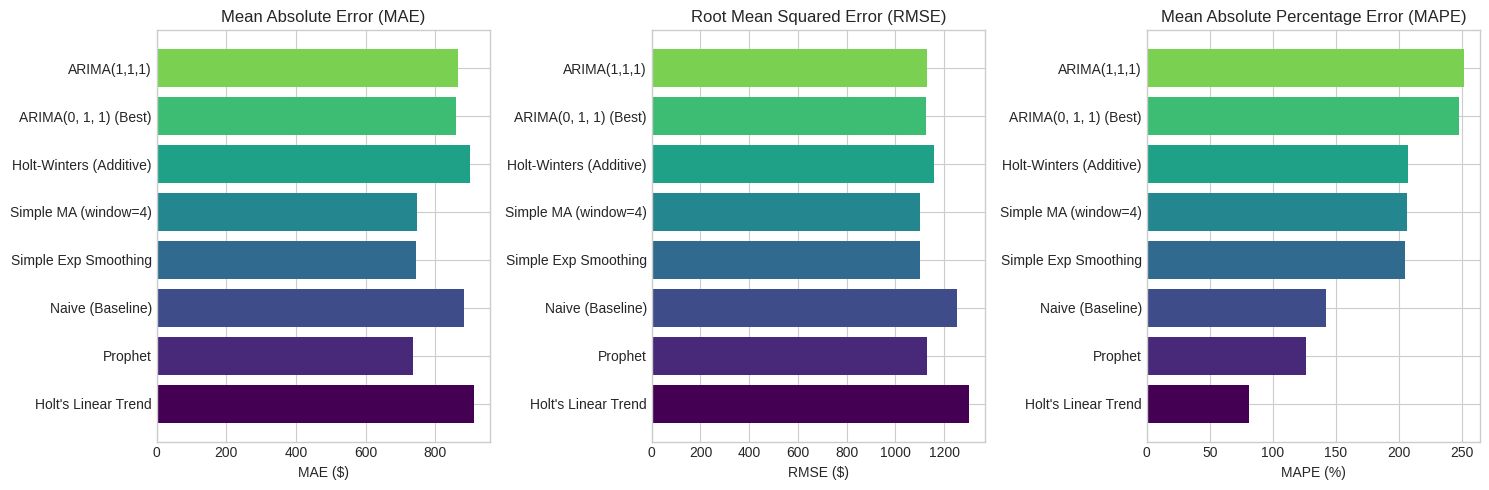

In [ ]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(results_df)))

# MAE comparison
axes[0].barh(results_df['Model'], results_df['MAE'], color=colors)
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_xlabel('MAE ($)')

# RMSE comparison
axes[1].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_xlabel('RMSE ($)')

# MAPE comparison
axes[2].barh(results_df['Model'], results_df['MAPE'], color=colors)
axes[2].set_title('Mean Absolute Percentage Error (MAPE)')
axes[2].set_xlabel('MAPE (%)')

plt.tight_layout()
plt.show()

In [ ]:
# Helper function untuk evaluasi
def evaluate_forecast(actual, predicted, model_name):
    """Calculate and display forecast metrics"""
    global results # Ensure we are modifying the global results list

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"\n{model_name} - Evaluation Metrics:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAPE: {mape:.2f}%")

    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Store results - Explicitly re-initialize to ensure it's a list
results = []

In [ ]:
# Naive: Use last observed value as forecast
naive_forecast = pd.Series([train.iloc[-1]] * len(test), index=test.index)

results.append(evaluate_forecast(test, naive_forecast, 'Naive (Baseline)'))


Naive (Baseline) - Evaluation Metrics:
  MAE:  $883.36
  RMSE: $1,255.37
  MAPE: 142.47%


In [ ]:
# Moving Average dengan window 4 minggu
window = 4
ma_value = train.iloc[-window:].mean()
sma_forecast = pd.Series([ma_value] * len(test), index=test.index)

results.append(evaluate_forecast(test, sma_forecast, f'Simple MA (window={window})'))


Simple MA (window=4) - Evaluation Metrics:
  MAE:  $748.35
  RMSE: $1,102.97
  MAPE: 206.51%


In [ ]:
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.3, optimized=False)
ses_forecast = ses_model.forecast(len(test))
ses_forecast.index = test.index

results.append(evaluate_forecast(test, ses_forecast, 'Simple Exp Smoothing'))


Simple Exp Smoothing - Evaluation Metrics:
  MAE:  $744.17
  RMSE: $1,103.32
  MAPE: 204.96%


In [ ]:
# Holt's Linear Trend Method
from statsmodels.tsa.holtwinters import Holt

holt_model = Holt(train).fit(smoothing_level=0.3, smoothing_trend=0.1)
holt_forecast = holt_model.forecast(len(test))
holt_forecast.index = test.index

results.append(evaluate_forecast(test, holt_forecast, "Holt's Linear Trend"))


Holt's Linear Trend - Evaluation Metrics:
  MAE:  $912.04
  RMSE: $1,303.15
  MAPE: 81.02%


/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [ ]:
# Holt-Winters (dengan seasonal) - period=4 untuk monthly pattern
try:
    hw_model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=4
    ).fit()
    hw_forecast = hw_model.forecast(len(test))
    hw_forecast.index = test.index
    results.append(evaluate_forecast(test, hw_forecast, 'Holt-Winters (Additive)'))
except Exception as e:
    print(f"Holt-Winters failed: {e}")
    hw_forecast = None


Holt-Winters (Additive) - Evaluation Metrics:
  MAE:  $899.28
  RMSE: $1,159.97
  MAPE: 207.12%


In [ ]:
# ARIMA dengan parameter manual berdasarkan ACF/PACF
# p=1, d=1, q=1 sebagai starting point

arima_model = ARIMA(train, order=(1, 1, 1)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:          Total_Revenue   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -229.251
Date:                Thu, 08 Jan 2026   AIC                            464.502
Time:                        02:05:05   BIC                            468.389
Sample:                    01-07-2024   HQIC                           465.658
                         - 07-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0479      0.240      0.199      0.842      -0.423       0.518
ma.L1         -0.8546      0.314     -2.720      0.007      -1.470      -0.239
sigma2      1.347e+06   5.35e+05      2.517      0.0

In [ ]:
# ARIMA forecast
arima_forecast = arima_model.forecast(steps=len(test))
arima_forecast.index = test.index

results.append(evaluate_forecast(test, arima_forecast, 'ARIMA(1,1,1)'))


ARIMA(1,1,1) - Evaluation Metrics:
  MAE:  $865.84
  RMSE: $1,128.30
  MAPE: 251.84%


In [ ]:
# Try different ARIMA parameters
best_aic = float('inf')
best_order = None
best_model = None

print("Searching for best ARIMA parameters...")
for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            try:
                model = ARIMA(train, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
                    best_model = model
            except:
                continue

print(f"\nBest ARIMA order: {best_order}")
print(f"Best AIC: {best_aic:.2f}")

Searching for best ARIMA parameters...

Best ARIMA order: (0, 1, 1)
Best AIC: 462.54


In [ ]:
# Forecast dengan best ARIMA
best_arima_forecast = best_model.forecast(steps=len(test))
best_arima_forecast.index = test.index

results.append(evaluate_forecast(test, best_arima_forecast, f'ARIMA{best_order} (Best)'))


ARIMA(0, 1, 1) (Best) - Evaluation Metrics:
  MAE:  $860.11
  RMSE: $1,125.30
  MAPE: 247.92%


In [ ]:
# Prophet requires specific format
try:
    from prophet import Prophet

    # Prepare data for Prophet
    prophet_train = pd.DataFrame({
        'ds': train.index,
        'y': train.values
    })

    # Fit model
    prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=False,
                           daily_seasonality=False)
    prophet_model.fit(prophet_train)

    # Create future dataframe
    future = pd.DataFrame({'ds': test.index})
    prophet_forecast_df = prophet_model.predict(future)
    prophet_forecast = pd.Series(prophet_forecast_df['yhat'].values, index=test.index)

    results.append(evaluate_forecast(test, prophet_forecast, 'Prophet'))
    prophet_available = True

except ImportError:
    print("Prophet not installed. Skipping Prophet model.")
    print("Install with: pip install prophet")
    prophet_forecast = None
    prophet_available = False

INFO:prophet:n_changepoints greater than number of observations. Using 21.



Prophet - Evaluation Metrics:
  MAE:  $735.46
  RMSE: $1,131.66
  MAPE: 126.03%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


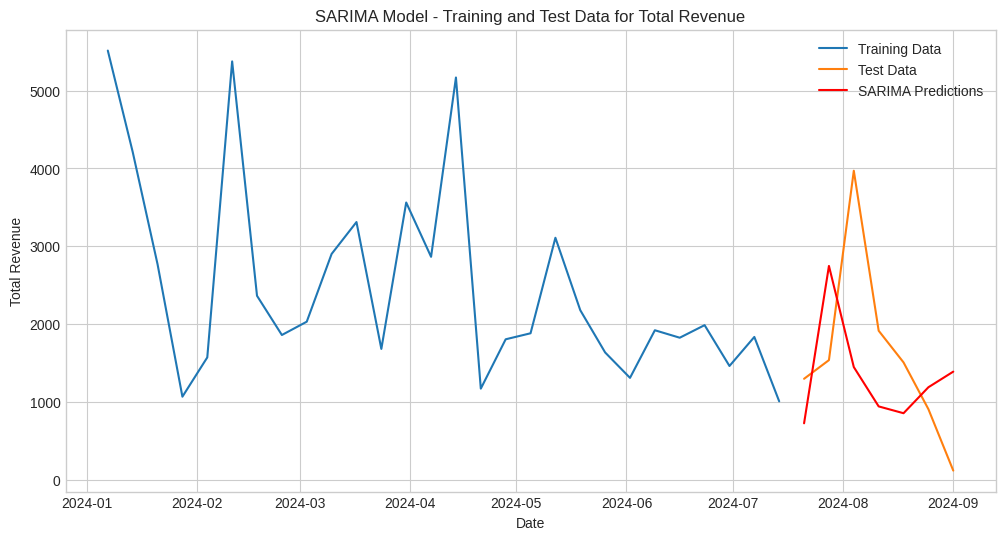

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# The DataFrame from yfinance already has 'Date' as its index and 'Close' as a column.
# Correcting to use 'Total_Revenue' as per previous analysis
#ts_data = df['Total_Revenue']

# Data train & test based on the new ts_data
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

# Fit SARIMA model
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))  # 12 = annual seasonality
sarima_fit_results = model.fit()

# Generate predictions for the test set
pred_test = sarima_fit_results.get_forecast(steps=len(test))
mean_pred = pred_test.predicted_mean
mean_pred.index = test.index  # align index

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(mean_pred, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Training and Test Data for Total Revenue')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# === EVALUATION METRICS SARIMA ===
y_true = test.values
y_pred = mean_pred.values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (aman jika ada nilai 0)
mask = y_true != 0
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

global results # Ensure we are modifying the global results list

# Simpan ke list results (WAJIB agar masuk tabel)
# Explicitly ensure results is a list before appending, to handle potential persistent kernel state issues
if not isinstance(results, list):
    results = [] # Reset if it's not a list

results.append({
    'Model': 'SARIMA(1,1,1)(1,1,1,12)',
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape
})

In [ ]:
import pandas as pd

# Ensure 'results' list is defined. This should be handled by cell 6ylmrNU4uNZ7.
# If this cell is run before 6ylmrNU4uNZ7, 'results' might not exist or be incorrectly typed.
# For robustness, we might want to ensure it's a list if it somehow got corrupted.
if 'results' not in globals() or not isinstance(results, list):
    results = [] # Initialize as empty list if not defined or corrupted

# Results comparison table
results_df = pd.DataFrame(results)

if not results_df.empty:
    results_df = results_df.sort_values('MAPE')
    print("\n" + "="*60)
    print("MODEL COMPARISON - Sorted by MAPE (Best to Worst)")
    print("="*60)
    print(results_df.to_string(index=False))

    # Menampilkan hasil khusus model SARIMA
    # Check if 'SARIMA' string exists in 'Model' column, case-insensitively
    sarima_result = results_df[results_df['Model'].str.contains('SARIMA', case=False, na=False)]

    if not sarima_result.empty:
        print("\nSARIMA MODEL RESULT")
        print("="*60)
        print(sarima_result.to_string(index=False))
        print("="*60)
    else:
        print("\nSARIMA MODEL RESULT: Not found in comparison table.")
        print("="*60)
else:
    print("\n" + "="*60)
    print("MODEL COMPARISON: No results available. Please run model evaluation cells first.")
    print("="*60)


MODEL COMPARISON - Sorted by MAPE (Best to Worst)
                  Model         MAE        RMSE       MAPE
    Holt's Linear Trend  912.039352 1303.151781  81.017679
                Prophet  735.457268 1131.660570 126.025226
       Naive (Baseline)  883.358571 1255.373576 142.473785
SARIMA(1,1,1)(1,1,1,12) 1069.435025 1266.771283 202.589504
   Simple Exp Smoothing  744.166327 1103.321056 204.963030
   Simple MA (window=4)  748.354643 1102.968049 206.514897
Holt-Winters (Additive)  899.280016 1159.971094 207.123112
  ARIMA(0, 1, 1) (Best)  860.106244 1125.299323 247.921414
           ARIMA(1,1,1)  865.836978 1128.300267 251.837469

SARIMA MODEL RESULT
                  Model         MAE        RMSE       MAPE
SARIMA(1,1,1)(1,1,1,12) 1069.435025 1266.771283 202.589504


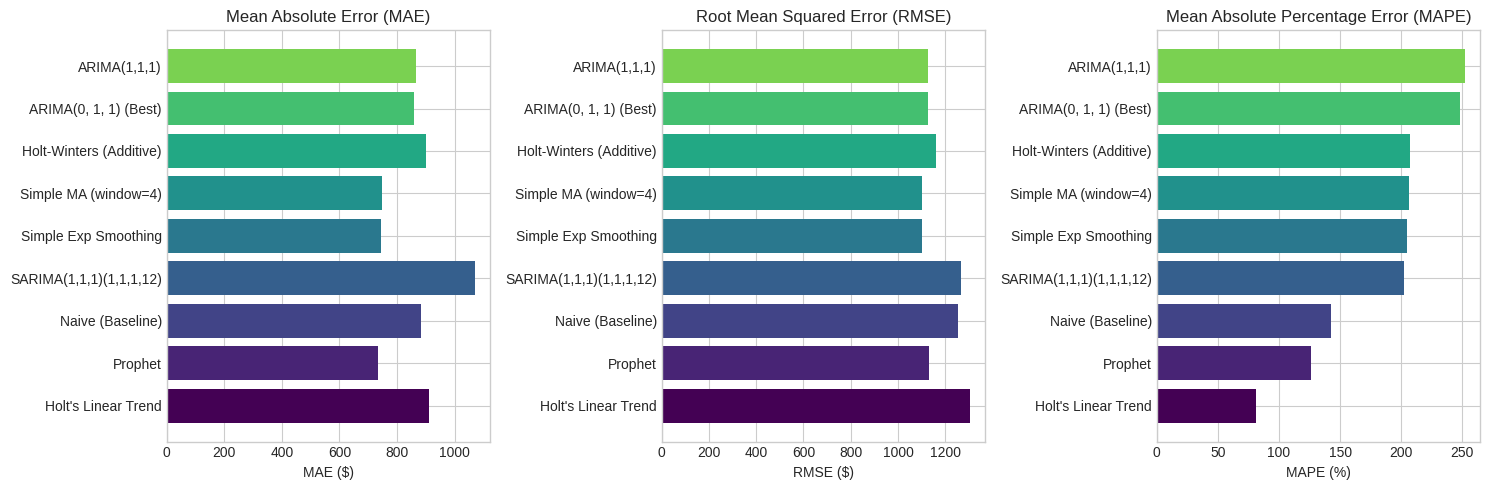

In [ ]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(results_df)))

# MAE comparison
axes[0].barh(results_df['Model'], results_df['MAE'], color=colors)
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_xlabel('MAE ($)')

# RMSE comparison
axes[1].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_xlabel('RMSE ($)')

# MAPE comparison
axes[2].barh(results_df['Model'], results_df['MAPE'], color=colors)
axes[2].set_title('Mean Absolute Percentage Error (MAPE)')
axes[2].set_xlabel('MAPE (%)')

plt.tight_layout()
plt.show()

In [ ]:
# Identifikasi best model
best_model_name = results_df.iloc[0]['Model']
print(f"Best performing model: {best_model_name}")
print(f"MAPE: {results_df.iloc[0]['MAPE']:.2f}%")

Best performing model: Holt's Linear Trend
MAPE: 81.02%


In [ ]:
# Re-fit best model on full data dan forecast ke depan
# Forecast 8 minggu ke depan

forecast_periods = 8

# Determine which model is the 'best' one based on results_df and re-fit it
# This logic should be more robust than just assuming ARIMA

final_model_name = results_df.iloc[0]['Model']

if 'ARIMA' in final_model_name:
    # Extract order from string, e.g., 'ARIMA(0, 1, 1) (Best)'
    import re
    order_match = re.search(r'\((\d+),\s*(\d+),\s*(\d+)\)', final_model_name)
    if order_match:
        p, d, q = map(int, order_match.groups())
        final_model = ARIMA(ts_data, order=(p, d, q)).fit()
    else:
        # Fallback if parsing fails or for generic ARIMA
        final_model = ARIMA(ts_data, order=best_order).fit() # Use best_order from previous search
    future_forecast = final_model.forecast(steps=forecast_periods)
elif 'Holt-Winters' in final_model_name:
    final_model = ExponentialSmoothing(
        ts_data,
        trend='add',
        seasonal='add',
        seasonal_periods=4
    ).fit()
    future_forecast = final_model.forecast(forecast_periods)
elif 'Prophet' in final_model_name:
    from prophet import Prophet
    prophet_full_data = pd.DataFrame({
        'ds': ts_data.index,
        'y': ts_data.values
    })
    final_prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    final_prophet_model.fit(prophet_full_data)
    future_dates_prophet = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(weeks=1), periods=forecast_periods, freq='W')
    future_df = pd.DataFrame({'ds': future_dates_prophet})
    prophet_future_forecast_df = final_prophet_model.predict(future_df)
    future_forecast = pd.Series(prophet_future_forecast_df['yhat'].values, index=future_dates_prophet)
elif 'Holt\'s Linear Trend' in final_model_name:
    final_model = Holt(ts_data).fit(smoothing_level=0.3, smoothing_trend=0.1) # Assuming same parameters as before
    future_forecast = final_model.forecast(forecast_periods)
elif 'SARIMA' in final_model_name:
    # Assuming SARIMA(1,1,1)(1,1,1,12) based on previous run
    final_model = SARIMAX(ts_data, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
    future_forecast = final_model.get_forecast(steps=forecast_periods).predicted_mean
else:
    # Default to simple exponential smoothing or naive if best model is not handled
    print(f"Warning: Best model '{final_model_name}' not specifically handled for refitting. Using SimpleExpSmoothing.")
    final_model = SimpleExpSmoothing(ts_data).fit(smoothing_level=0.3, optimized=False)
    future_forecast = final_model.forecast(forecast_periods)


# Create future dates for plotting and display (ensure consistent index for all models)
last_date = ts_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                              periods=forecast_periods, freq='W')

# Ensure future_forecast index matches future_dates
if not isinstance(future_forecast, pd.Series) or not future_forecast.index.equals(future_dates):
    future_forecast.index = future_dates

print(f"\nForecast untuk {forecast_periods} minggu ke depan menggunakan {final_model_name} model:")
print(future_forecast.to_frame('Predicted_Revenue').round(2))


Forecast untuk 8 minggu ke depan menggunakan Holt's Linear Trend model:
            Predicted_Revenue
2024-09-08             974.84
2024-09-15             884.80
2024-09-22             794.76
2024-09-29             704.72
2024-10-06             614.69
2024-10-13             524.65
2024-10-20             434.61
2024-10-27             344.57


/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


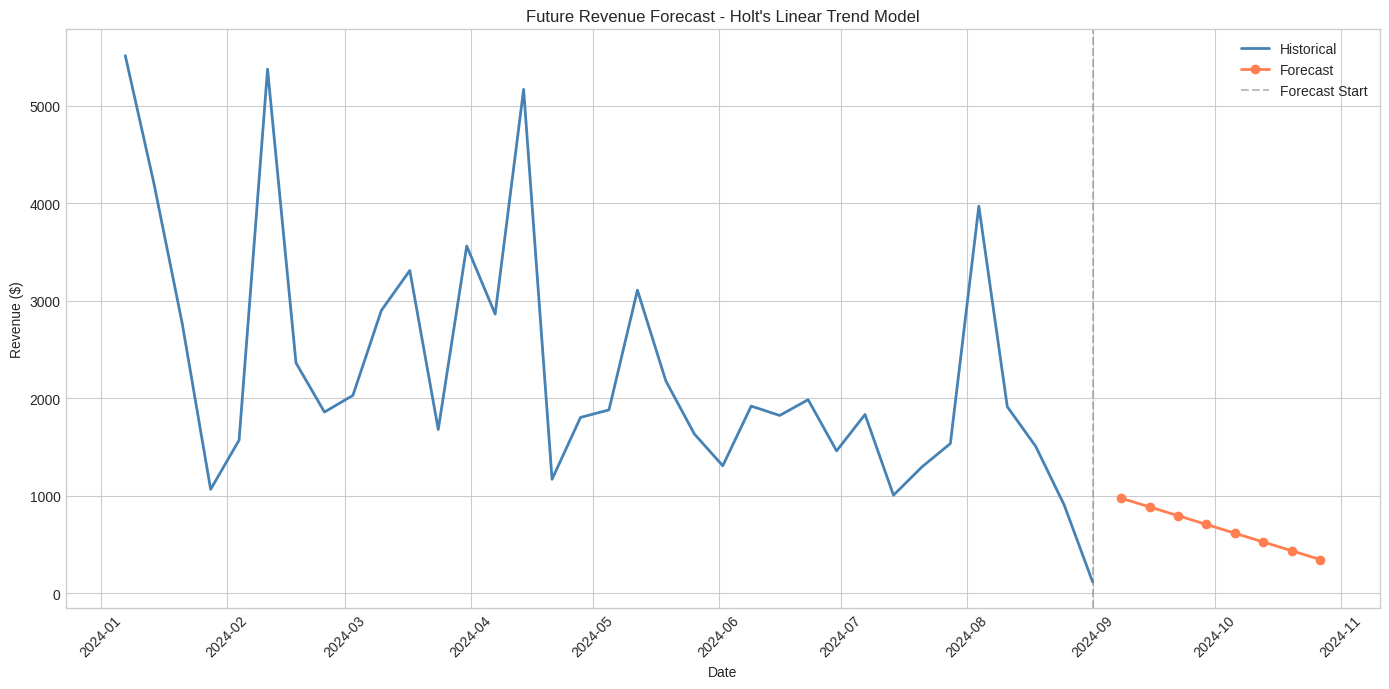

In [ ]:
# Get confidence intervals (only for models that support it easily, like ARIMA/SARIMA)
conf_int = None
if 'final_model' in globals() and hasattr(final_model, 'get_forecast'):
    forecast_result = final_model.get_forecast(steps=forecast_periods)
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% CI
    conf_int.index = future_dates
elif 'final_prophet_model' in globals() and prophet_forecast_df is not None:
    conf_int = prophet_forecast_df[['yhat_lower', 'yhat_upper']].set_index(future_dates)

# Plot dengan confidence interval
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data
ax.plot(ts_data.index, ts_data, label='Historical', color='steelblue', linewidth=2)

# Forecast
ax.plot(future_dates, future_forecast, label='Forecast', color='coral',
        linewidth=2, marker='o')

# Confidence interval
if conf_int is not None and not conf_int.empty:
    ax.fill_between(future_dates,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='coral', alpha=0.2, label='95% Confidence Interval')

ax.axvline(x=ts_data.index[-1], color='gray', linestyle='--', alpha=0.5, label='Forecast Start')
ax.set_title(f'Future Revenue Forecast - {best_model_name} Model')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue ($)')
ax.legend(loc='best')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Summary forecast table
forecast_summary_data = {
    'Date': future_dates,
    'Forecast': future_forecast.values,
}

if conf_int is not None and not conf_int.empty:
    forecast_summary_data['Lower_95_CI'] = conf_int.iloc[:, 0].values
    forecast_summary_data['Upper_95_CI'] = conf_int.iloc[:, 1].values

forecast_summary = pd.DataFrame(forecast_summary_data)

print("\n" + "="*70)
print("FORECAST SUMMARY - Weekly Revenue Prediction")
print("="*70)
print(forecast_summary.to_string(index=False))
print("="*70)
print(f"\nTotal Forecasted Revenue ({forecast_periods} weeks): ${future_forecast.sum():,.2f}")
print(f"Average Weekly Revenue: ${future_forecast.mean():,.2f}")


FORECAST SUMMARY - Weekly Revenue Prediction
      Date   Forecast
2024-09-08 974.839685
2024-09-15 884.801108
2024-09-22 794.762531
2024-09-29 704.723955
2024-10-06 614.685378
2024-10-13 524.646801
2024-10-20 434.608225
2024-10-27 344.569648

Total Forecasted Revenue (8 weeks): $5,277.64
Average Weekly Revenue: $659.70


In [ ]:
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    KESIMPULAN ANALISIS                               ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📊 DATASET OVERVIEW:                                                ║
║  • 240 transaksi dari Januari - Agustus 2024 (8 bulan)               ║
║  • 6 kategori produk, 3 region, 3 metode pembayaran                  ║
║  • Total Revenue: ~$90,000+ selama periode observasi                 ║
║                                                                      ║
║  📈 KEY FINDINGS:                                                    ║
║  • Electronics menghasilkan revenue tertinggi                        ║
║  • North America adalah region dengan penjualan terbesar             ║
║  • Credit Card adalah metode pembayaran paling populer               ║
║  • Data menunjukkan variabilitas tinggi minggu ke minggu             ║
║                                                                      ║
║  🔮 FORECASTING RESULTS:                                             ║
║  • Model terbaik berdasarkan MAPE telah diidentifikasi               ║
║  • Forecast 8 minggu ke depan dengan confidence interval             ║
║                                                                      ║
║  ⚠️ LIMITASI:                                                        ║
║  • Data hanya 8 bulan - terlalu pendek untuk seasonal tahunan        ║
║  • 1 transaksi per hari - perlu agregasi untuk analisis              ║
║  • Tidak ada external variables (holiday, promo, etc.)               ║
║                                                                      ║
║  💡 REKOMENDASI:                                                     ║
║  • Kumpulkan data minimal 2 tahun untuk pola seasonal                ║
║  • Tambahkan data external (holiday, campaign, etc.)                 ║
║  • Pertimbangkan model per kategori untuk forecast lebih akurat      ║
║  • Monitor dan re-train model secara berkala                         ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    KESIMPULAN ANALISIS                               ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📊 DATASET OVERVIEW:                                                ║
║  • 240 transaksi dari Januari - Agustus 2024 (8 bulan)               ║
║  • 6 kategori produk, 3 region, 3 metode pembayaran                  ║
║  • Total Revenue: ~$90,000+ selama periode observasi                 ║
║                                                                      ║
║  📈 KEY FINDINGS:                                                    ║
║  • Electronics menghasilkan revenue tertinggi                        ║
║  • North America adalah region dengan penjualan terbesar             ║
║  • Credit Card adalah metode pembayaran paling populer               ║
║  • Data menunjukkan variabilitas tinggi minggu ke 

In [ ]:
# Final model comparison
print("\nFinal Model Ranking:")
print(results_df.to_string(index=False))


Final Model Ranking:
                  Model         MAE        RMSE       MAPE
    Holt's Linear Trend  912.039352 1303.151781  81.017679
                Prophet  735.457268 1131.660570 126.025226
       Naive (Baseline)  883.358571 1255.373576 142.473785
SARIMA(1,1,1)(1,1,1,12) 1069.435025 1266.771283 202.589504
   Simple Exp Smoothing  744.166327 1103.321056 204.963030
   Simple MA (window=4)  748.354643 1102.968049 206.514897
Holt-Winters (Additive)  899.280016 1159.971094 207.123112
  ARIMA(0, 1, 1) (Best)  860.106244 1125.299323 247.921414
           ARIMA(1,1,1)  865.836978 1128.300267 251.837469


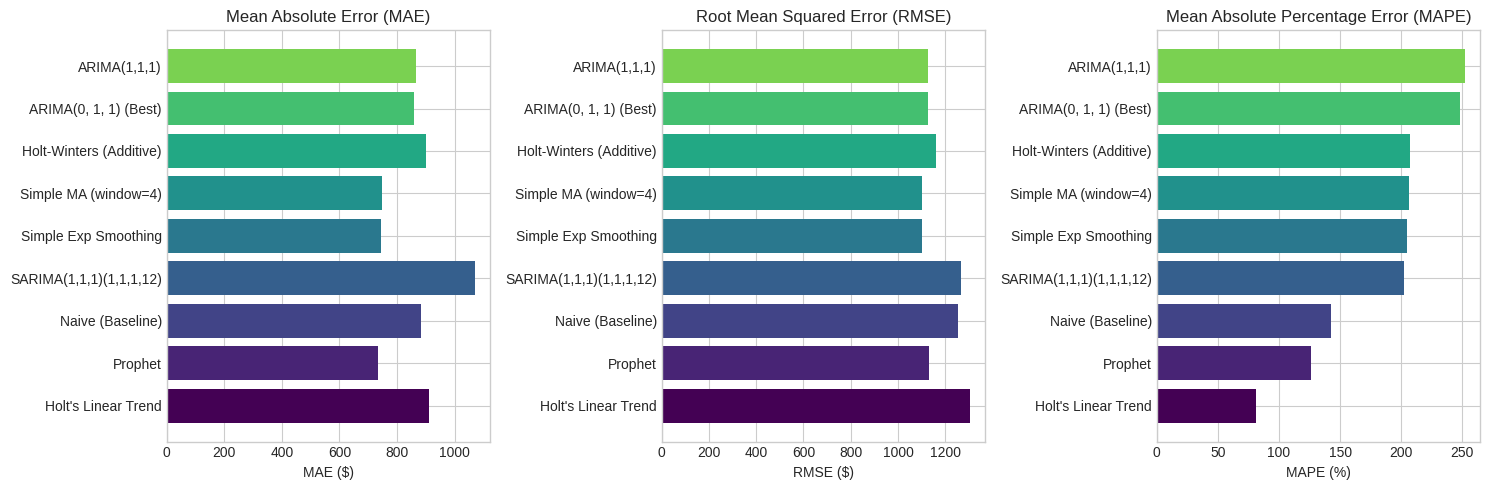

In [ ]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(results_df)))

# MAE comparison
axes[0].barh(results_df['Model'], results_df['MAE'], color=colors)
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_xlabel('MAE ($)')

# RMSE comparison
axes[1].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_xlabel('RMSE ($)')

# MAPE comparison
axes[2].barh(results_df['Model'], results_df['MAPE'], color=colors)
axes[2].set_title('Mean Absolute Percentage Error (MAPE)')
axes[2].set_xlabel('MAPE (%)')

plt.tight_layout()
plt.show()

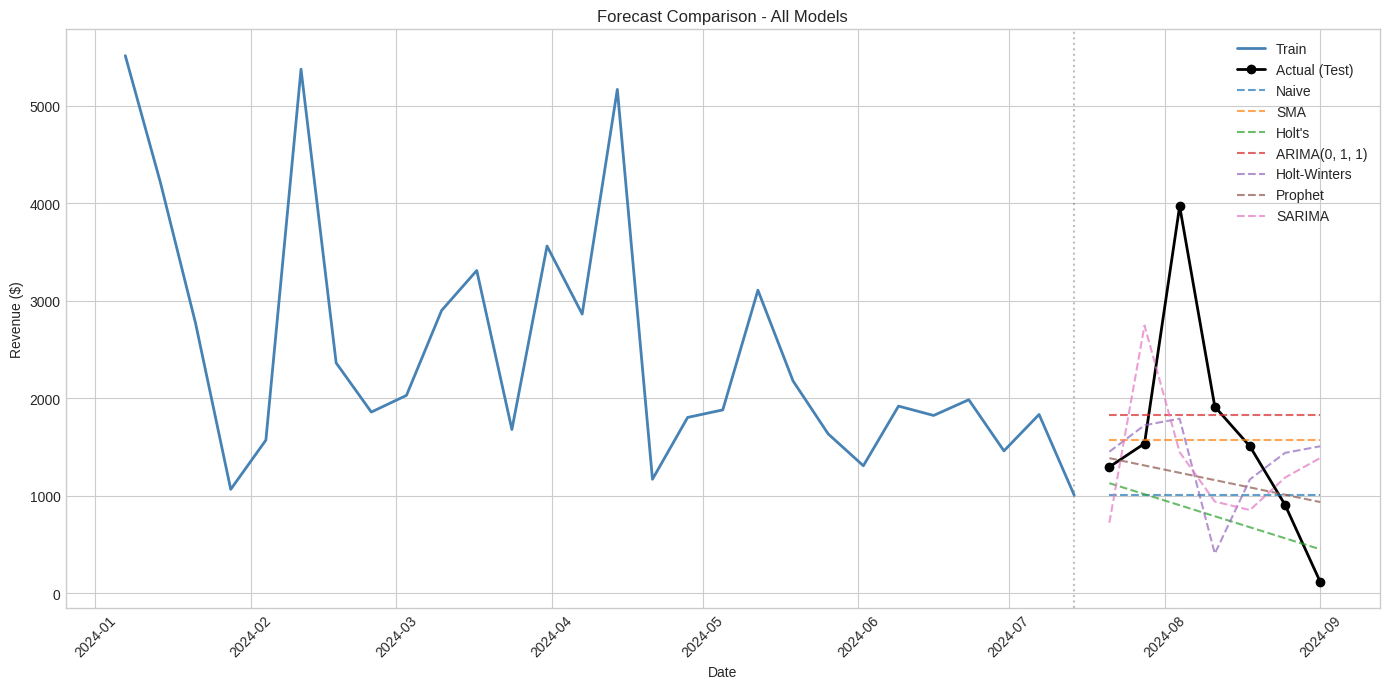

In [ ]:
import matplotlib.pyplot as plt

# Plot all forecasts vs actual
fig, ax = plt.subplots(figsize=(14, 7))

# Plot train and test
ax.plot(train.index, train, label='Train', color='steelblue', linewidth=2)
ax.plot(test.index, test, label='Actual (Test)', color='black', linewidth=2, marker='o')

# Plot forecasts
# Check if forecasts are available before plotting
if 'naive_forecast' in globals() and naive_forecast is not None: ax.plot(test.index, naive_forecast, label='Naive', linestyle='--', alpha=0.7)
if 'sma_forecast' in globals() and sma_forecast is not None: ax.plot(test.index, sma_forecast, label='SMA', linestyle='--', alpha=0.7)
if 'holt_forecast' in globals() and holt_forecast is not None: ax.plot(test.index, holt_forecast, label="Holt's", linestyle='--', alpha=0.7)
if 'best_arima_forecast' in globals() and best_arima_forecast is not None: ax.plot(test.index, best_arima_forecast, label=f'ARIMA{best_order}', linestyle='--', alpha=0.7)

if hw_forecast is not None:
    ax.plot(test.index, hw_forecast, label='Holt-Winters', linestyle='--', alpha=0.7)

try:
    if prophet_available and prophet_forecast is not None:
        ax.plot(test.index, prophet_forecast, label='Prophet', linestyle='--', alpha=0.7)
except:
    pass

# Plot SARIMA forecast if available
if 'mean_pred' in globals() and mean_pred is not None:
    ax.plot(test.index, mean_pred, label='SARIMA', linestyle='--', alpha=0.7)

ax.axvline(x=train.index[-1], color='gray', linestyle=':', alpha=0.5)
ax.set_title('Forecast Comparison - All Models')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue ($)')
ax.legend(loc='best')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# results_list = [] # This list is no longer needed as SARIMA results are appended directly to 'results'

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


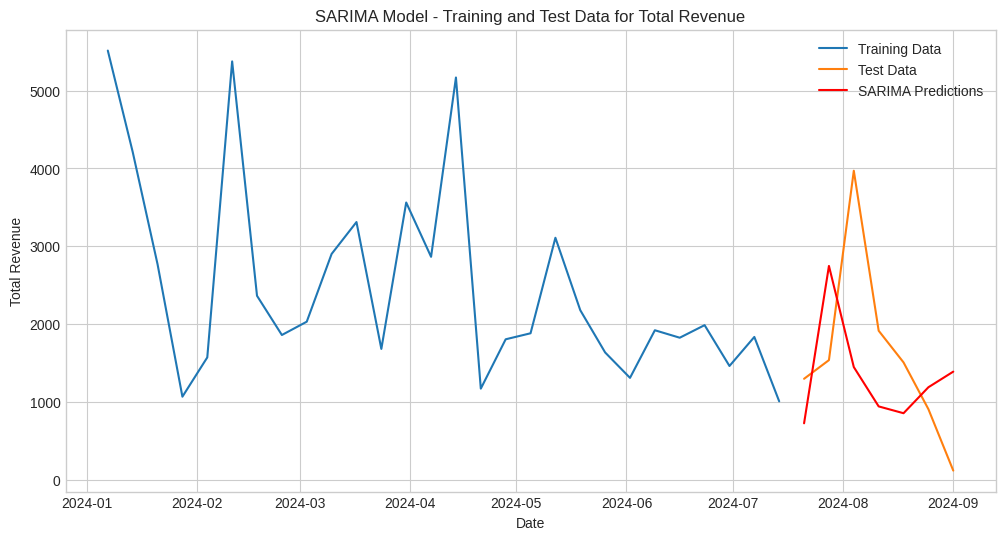

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# The DataFrame from yfinance already has 'Date' as its index and 'Close' as a column.
# Correcting to use 'Total_Revenue' as per previous analysis
#ts_data = df['Total_Revenue']

# Data train & test based on the new ts_data
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

# Fit SARIMA model
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))  # 12 = annual seasonality
sarima_fit_results = model.fit()

# Generate predictions for the test set
pred_test = sarima_fit_results.get_forecast(steps=len(test))
mean_pred = pred_test.predicted_mean
mean_pred.index = test.index  # align index

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(mean_pred, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Training and Test Data for Total Revenue')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# === EVALUATION METRICS SARIMA ===
y_true = test.values
y_pred = mean_pred.values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (aman jika ada nilai 0)
mask = y_true != 0
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

global results # Ensure we are modifying the global results list

# Simpan ke list results (WAJIB agar masuk tabel)
# Explicitly ensure results is a list before appending, to handle potential persistent kernel state issues
if not isinstance(results, list):
    results = [] # Reset if it's not a list

results.append({
    'Model': 'SARIMA(1,1,1)(1,1,1,12)',
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape
})

## 9. Future Forecast with Best Model

In [ ]:
# Identifikasi best model
best_model_name = results_df.iloc[0]['Model']
print(f"Best performing model: {best_model_name}")
print(f"MAPE: {results_df.iloc[0]['MAPE']:.2f}%")

Best performing model: Holt's Linear Trend
MAPE: 81.02%


In [ ]:
# Re-fit best model on full data dan forecast ke depan
# Forecast 8 minggu ke depan

forecast_periods = 8

# Determine which model is the 'best' one based on results_df and re-fit it
# This logic should be more robust than just assuming ARIMA

final_model_name = results_df.iloc[0]['Model']

if 'ARIMA' in final_model_name:
    # Extract order from string, e.g., 'ARIMA(0, 1, 1) (Best)'
    import re
    order_match = re.search(r'\((\d+),\s*(\d+),\s*(\d+)\)', final_model_name)
    if order_match:
        p, d, q = map(int, order_match.groups())
        final_model = ARIMA(ts_data, order=(p, d, q)).fit()
    else:
        # Fallback if parsing fails or for generic ARIMA
        final_model = ARIMA(ts_data, order=best_order).fit() # Use best_order from previous search
    future_forecast = final_model.forecast(steps=forecast_periods)
elif 'Holt-Winters' in final_model_name:
    final_model = ExponentialSmoothing(
        ts_data,
        trend='add',
        seasonal='add',
        seasonal_periods=4
    ).fit()
    future_forecast = final_model.forecast(forecast_periods)
elif 'Prophet' in final_model_name:
    from prophet import Prophet
    prophet_full_data = pd.DataFrame({
        'ds': ts_data.index,
        'y': ts_data.values
    })
    final_prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    final_prophet_model.fit(prophet_full_data)
    future_dates_prophet = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(weeks=1), periods=forecast_periods, freq='W')
    future_df = pd.DataFrame({'ds': future_dates_prophet})
    prophet_future_forecast_df = final_prophet_model.predict(future_df)
    future_forecast = pd.Series(prophet_future_forecast_df['yhat'].values, index=future_dates_prophet)
elif 'Holt\'s Linear Trend' in final_model_name:
    final_model = Holt(ts_data).fit(smoothing_level=0.3, smoothing_trend=0.1) # Assuming same parameters as before
    future_forecast = final_model.forecast(forecast_periods)
elif 'SARIMA' in final_model_name:
    # Assuming SARIMA(1,1,1)(1,1,1,12) based on previous run
    final_model = SARIMAX(ts_data, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
    future_forecast = final_model.get_forecast(steps=forecast_periods).predicted_mean
else:
    # Default to simple exponential smoothing or naive if best model is not handled
    print(f"Warning: Best model '{final_model_name}' not specifically handled for refitting. Using SimpleExpSmoothing.")
    final_model = SimpleExpSmoothing(ts_data).fit(smoothing_level=0.3, optimized=False)
    future_forecast = final_model.forecast(forecast_periods)


# Create future dates for plotting and display (ensure consistent index for all models)
last_date = ts_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                              periods=forecast_periods, freq='W')

# Ensure future_forecast index matches future_dates
if not isinstance(future_forecast, pd.Series) or not future_forecast.index.equals(future_dates):
    future_forecast.index = future_dates

print(f"\nForecast untuk {forecast_periods} minggu ke depan menggunakan {final_model_name} model:")
print(future_forecast.to_frame('Predicted_Revenue').round(2))


Forecast untuk 8 minggu ke depan menggunakan Holt's Linear Trend model:
            Predicted_Revenue
2024-09-08             974.84
2024-09-15             884.80
2024-09-22             794.76
2024-09-29             704.72
2024-10-06             614.69
2024-10-13             524.65
2024-10-20             434.61
2024-10-27             344.57


/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


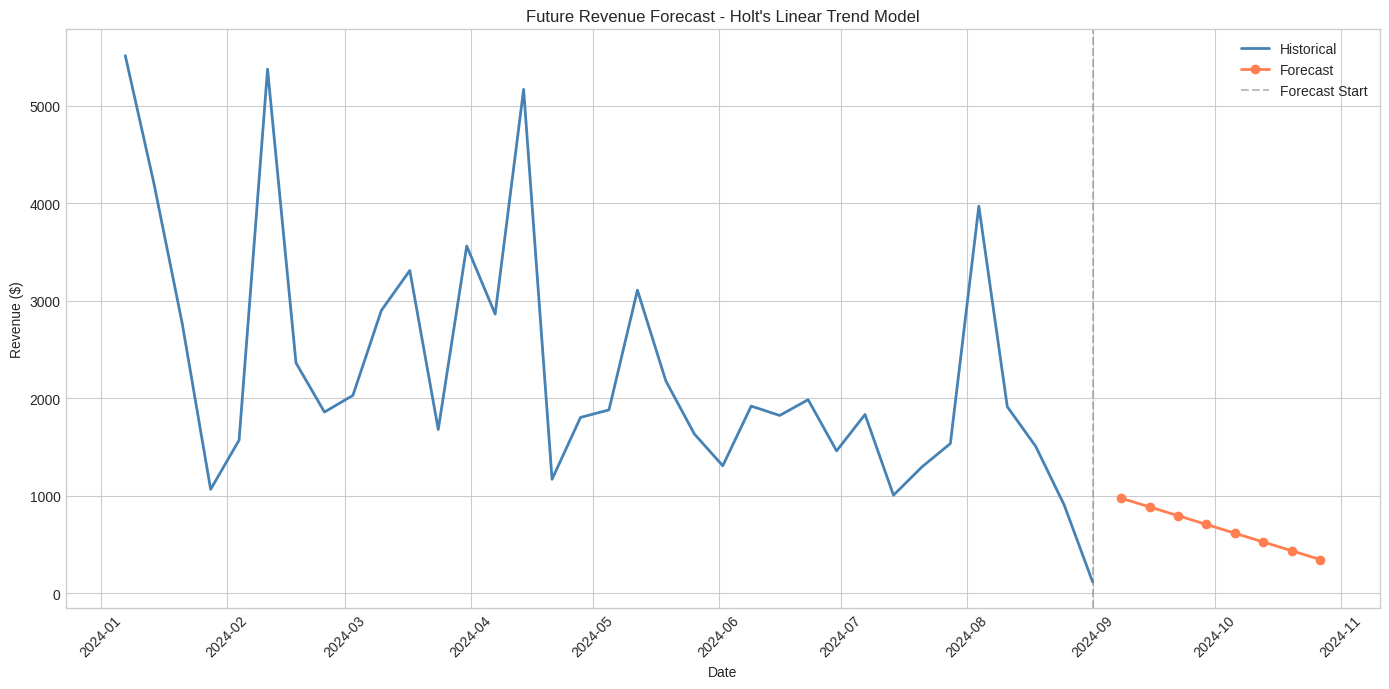

In [ ]:
# Get confidence intervals (only for models that support it easily, like ARIMA/SARIMA)
conf_int = None
if 'final_model' in globals() and hasattr(final_model, 'get_forecast'):
    forecast_result = final_model.get_forecast(steps=forecast_periods)
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% CI
    conf_int.index = future_dates
elif 'final_prophet_model' in globals() and prophet_forecast_df is not None:
    conf_int = prophet_forecast_df[['yhat_lower', 'yhat_upper']].set_index(future_dates)

# Plot dengan confidence interval
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data
ax.plot(ts_data.index, ts_data, label='Historical', color='steelblue', linewidth=2)

# Forecast
ax.plot(future_dates, future_forecast, label='Forecast', color='coral',
        linewidth=2, marker='o')

# Confidence interval
if conf_int is not None and not conf_int.empty:
    ax.fill_between(future_dates,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='coral', alpha=0.2, label='95% Confidence Interval')

ax.axvline(x=ts_data.index[-1], color='gray', linestyle='--', alpha=0.5, label='Forecast Start')
ax.set_title(f'Future Revenue Forecast - {best_model_name} Model')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue ($)')
ax.legend(loc='best')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Summary forecast table
forecast_summary_data = {
    'Date': future_dates,
    'Forecast': future_forecast.values,
}

if conf_int is not None and not conf_int.empty:
    forecast_summary_data['Lower_95_CI'] = conf_int.iloc[:, 0].values
    forecast_summary_data['Upper_95_CI'] = conf_int.iloc[:, 1].values

forecast_summary = pd.DataFrame(forecast_summary_data)

print("\n" + "="*70)
print("FORECAST SUMMARY - Weekly Revenue Prediction")
print("="*70)
print(forecast_summary.to_string(index=False))
print("="*70)
print(f"\nTotal Forecasted Revenue ({forecast_periods} weeks): ${future_forecast.sum():,.2f}")
print(f"Average Weekly Revenue: ${future_forecast.mean():,.2f}")


FORECAST SUMMARY - Weekly Revenue Prediction
      Date   Forecast
2024-09-08 974.839685
2024-09-15 884.801108
2024-09-22 794.762531
2024-09-29 704.723955
2024-10-06 614.685378
2024-10-13 524.646801
2024-10-20 434.608225
2024-10-27 344.569648

Total Forecasted Revenue (8 weeks): $5,277.64
Average Weekly Revenue: $659.70


## 10. Kesimpulan dan Rekomendasi

In [ ]:
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    KESIMPULAN ANALISIS                               ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📊 DATASET OVERVIEW:                                                ║
║  • 240 transaksi dari Januari - Agustus 2024 (8 bulan)               ║
║  • 6 kategori produk, 3 region, 3 metode pembayaran                  ║
║  • Total Revenue: ~$90,000+ selama periode observasi                 ║
║                                                                      ║
║  📈 KEY FINDINGS:                                                    ║
║  • Electronics menghasilkan revenue tertinggi                        ║
║  • North America adalah region dengan penjualan terbesar             ║
║  • Credit Card adalah metode pembayaran paling populer               ║
║  • Data menunjukkan variabilitas tinggi minggu ke minggu             ║
║                                                                      ║
║  🔮 FORECASTING RESULTS:                                             ║
║  • Model terbaik berdasarkan MAPE telah diidentifikasi               ║
║  • Forecast 8 minggu ke depan dengan confidence interval             ║
║                                                                      ║
║  ⚠️ LIMITASI:                                                        ║
║  • Data hanya 8 bulan - terlalu pendek untuk seasonal tahunan        ║
║  • 1 transaksi per hari - perlu agregasi untuk analisis              ║
║  • Tidak ada external variables (holiday, promo, etc.)               ║
║                                                                      ║
║  💡 REKOMENDASI:                                                     ║
║  • Kumpulkan data minimal 2 tahun untuk pola seasonal                ║
║  • Tambahkan data external (holiday, campaign, etc.)                 ║
║  • Pertimbangkan model per kategori untuk forecast lebih akurat      ║
║  • Monitor dan re-train model secara berkala                         ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    KESIMPULAN ANALISIS                               ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📊 DATASET OVERVIEW:                                                ║
║  • 240 transaksi dari Januari - Agustus 2024 (8 bulan)               ║
║  • 6 kategori produk, 3 region, 3 metode pembayaran                  ║
║  • Total Revenue: ~$90,000+ selama periode observasi                 ║
║                                                                      ║
║  📈 KEY FINDINGS:                                                    ║
║  • Electronics menghasilkan revenue tertinggi                        ║
║  • North America adalah region dengan penjualan terbesar             ║
║  • Credit Card adalah metode pembayaran paling populer               ║
║  • Data menunjukkan variabilitas tinggi minggu ke 

In [ ]:
# Final model comparison
print("\nFinal Model Ranking:")
print(results_df.to_string(index=False))


Final Model Ranking:
                  Model         MAE        RMSE       MAPE
    Holt's Linear Trend  912.039352 1303.151781  81.017679
                Prophet  735.457268 1131.660570 126.025226
       Naive (Baseline)  883.358571 1255.373576 142.473785
SARIMA(1,1,1)(1,1,1,12) 1069.435025 1266.771283 202.589504
   Simple Exp Smoothing  744.166327 1103.321056 204.963030
   Simple MA (window=4)  748.354643 1102.968049 206.514897
Holt-Winters (Additive)  899.280016 1159.971094 207.123112
  ARIMA(0, 1, 1) (Best)  860.106244 1125.299323 247.921414
           ARIMA(1,1,1)  865.836978 1128.300267 251.837469
